In [15]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

---

## My Code


---

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# LinearSVC
polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge"))
    ])

# from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

# Similarity function
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

---

In [ ]:
# Measuring Accuracy Using Cross-Validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=10, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

def plot_clf_perf(y_train, y_pred, precision, recall, thres, fpr, tpr, confmx):
    plt.figure(figsize=(15,10))
    plt.subplot(223)
    plot_precision_recall_vs_threshold(precision, recall, thres)
    plt.subplot(211)
    plot_precision_vs_recall(precision, recall)
    plt.subplot(224)
    check_performance(y_train, y_train_pred)

    plt.show()
    
def check_performance(y_true, pred, color="g", ann=True):
    acc = accuracy_score(y_true, pred, 0.5)
    auc = roc_auc_score(y_true, pred)
    plt.annotate("Acc: %0.2f" % acc, (0.2,0.7), size=14)
    plt.annotate("AUC: %0.2f" % auc, (0.2,0.6), size=14)
    fpr, tpr, thr = roc_curve(y_true, pred)
    plt.plot(fpr, tpr, color, linewidth="3")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
def plot_confusion_matrix(matrix):
    plt.matshow(matrix, cmap=plt.cm.hot)
#    plt.colorbar()

precision, recall, f = precision_recall_curve(y_train, y_scores)
fpr, tpr, t = roc_curve(y_train, y_scores)
conf_mx = confusion_matrix(y_train, y_train_pred)

# Plot Precision vs Recall curves
plot_clf_perf(y_train, y_train_pred, precision, recall, f, fpr, tpr, conf_mx)

#confusion_matrix(y_train, y_train_pred)

#correctly predicted 2609 instances going down, and missed 6200. Correctly predicted 6821 instances going upwards but missed 2645

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


print('Precision:',precision_score(y_train, y_train_pred),
      '\nRecall:',recall_score(y_train, y_train_pred),
     '\nF1Score:',f1_score(y_train, y_train_pred), 
     '\nAUC:',roc_auc_score(y_train, y_scores))

---

---

```python
# Get good examples of assetcodes that have at least 2 news in different dates AND present in the market: 

#mkt.loc[mkt.assetCode=='CEA.N']
ac = nws.loc[(nws.time>='2007-01-03 00:00:00+00:00')&(nws.time<'2007-01-04 00:00:00+00:00')].assetCode.values

uc = nws.loc[(nws.time>='2007-01-04 00:00:00+00:00')&(nws.assetCode.isin(ac))].assetCode.unique()

# Asset codes that have more than 1 pieces of news in the same date 
zzz = nws.assetCode.value_counts()
dc = zzz[zzz>5].index.values
ass_codes = [dif_date for dif_date in uc if dif_date in dc]
mkt.loc[mkt.assetCode.isin(ass_codes),'assetCode'].unique()[:10]
```

---

In [ ]:
import random
import pandas as pd
import numpy as np
import dateutil.parser as p
import matplotlib.pyplot as plt

# Hide deprecation warnings
import warnings
warnings.filterwarnings('ignore')

## Baseline vs Optimal Clfs
Add results

In [173]:
results = '''DecTree	(76968, 48)	556.32931	0.521788	0.5403	0.66537	0.596348	0.478212	0.512328	{'max_leaf_nodes': 93, 'min_samples_leaf': 7, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0}
DecTree	(76968, 48)	0.801244	0.484253	0.517784	0.415755	0.461194	0.515747	0.488767	Baseline
KNN	(76968, 48)	358.918415	0.503235	0.532775	0.522722	0.527701	0.496765	0.501951	Baseline
LogReg	(76968, 48)	1686.918128	0.489905	0.518588	0.546876	0.532357	0.510095	0.486151	{'C': 1, 'penalty': 'l1'}
LogReg	(76968, 48)	23.256982	0.487099	0.516149	0.542031	0.528774	0.512901	0.483479	Baseline
RandFor	(76968, 48)	638.949979	0.518748	0.536915	0.6802	0.600123	0.481252	0.50811	{'criterion': 'gini', 'max_leaf_nodes': 91, 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 49}
RandFor	(76968, 48)	5.780340	0.495401	0.532263	0.408781	0.462420	0.504599	0.501108	Baseline
SGD	(76968, 48)	0.218333	0.484253	0.517784	0.415755	0.461194	0.515747	0.488767	Baseline
SGD	(76968, 48)	130.780076	0.480901	0.511337	0.501652	0.506448	0.519099	0.479534	{'alpha': 0.01, 'l1_ratio': 0, 'loss': 'log', 'penalty': 'elasticnet'}
XTrees	(76968, 48)	223.456979	0.529038	0.531174	0.96197	0.684426	0.470962	0.500512	{'criterion': 'gini', 'max_leaf_nodes': 91, 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 41}
XTrees	(76968, 48)	2.753044	0.493491	0.530038	0.405477	0.459465	0.506509	0.499290	Baseline
KNN	(76968, 48)	4871.63213	0.500624	0.528825	0.54482	0.536704	0.499376	0.497711	{'n_neighbors': 21}'''

In [174]:
n_cols = ['Algos','data_size','ETA','Acc','Precision','Recall','F1','MSE','AUC','Params']
import pandas as pd
# Initialize dataframe
df = pd.DataFrame(columns=n_cols)
# Fill info
for i,r1 in enumerate(results.split('\n')):
    df.loc[i] = r1.split('\t')
# Set index
df.set_index('Algos', inplace=True)
df.to_csv('data/BaselineVsGridsearch2008.csv')
df.head()

,data_size,ETA,Acc,Precision,Recall,F1,MSE,AUC,Params
Algos,,,,,,,,,
DecTree,"(76968, 48)",556.32931,0.521788,0.5403,0.66537,0.596348,0.478212,0.512328,"{'max_leaf_nodes': 93, 'min_samples_leaf': 7, ..."
DecTree,"(76968, 48)",0.801244,0.484253,0.517784,0.415755,0.461194,0.515747,0.488767,Baseline
KNN,"(76968, 48)",358.918415,0.503235,0.532775,0.522722,0.527701,0.496765,0.501951,Baseline
LogReg,"(76968, 48)",1686.918128,0.489905,0.518588,0.546876,0.532357,0.510095,0.486151,"{'C': 1, 'penalty': 'l1'}"
LogReg,"(76968, 48)",23.256982,0.487099,0.516149,0.542031,0.528774,0.512901,0.483479,Baseline


Prep for comparison

In [1294]:
df = pd.read_csv('data/BaselineVsGridsearch2008.csv')
#df = df.loc[(df.Algos != 'LinSVC'), ['Algos','Acc','Precision','Recall','F1','MSE','AUC','Params']]
df['modes'] = ['Baseline' if row.Params == 'Baseline' else 'GridSearch' for _, row in df.iterrows()]
df['group'] = df.apply(lambda row: str(row.Algos)+' '+str(row.modes), axis=1)
df.set_index('group', inplace=True)
df.reset_index(inplace=True)
feats = ['Algos','modes','Acc','Precision','Recall','F1','MSE','AUC']
df.loc[:,feats].head()

,Algos,modes,Acc,Precision,Recall,F1,MSE,AUC
0,LogReg,Baseline,0.514851,0.550966,0.079323,0.138681,0.485149,0.508309
1,SGD,Baseline,0.501806,0.493510,0.449293,0.470365,0.498194,0.501018
2,DecTree,Baseline,0.501806,0.493510,0.449293,0.470365,0.498194,0.501018
3,XTrees,Baseline,0.513063,0.507095,0.394686,0.443885,0.486937,0.511285
4,RandFor,Baseline,0.521962,0.520297,0.373214,0.434650,0.478038,0.519728


In [1295]:
# ------- PART 1: Define a function that do a plot for one line of the dataset!
from math import pi

def make_spider(row, title, color):
    # number of variable
    categories=list(df_plot)[2:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]   

    # Initialise the spider plot
    ax = plt.subplot(2,3,(row//2)+1, polar=True, )


    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=36)

    # Draw ylabels
    #ax.set_rlabel_position(0)
    #plt.yticks([0.40,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8], color="black", size=8)
    #plt.ylim(0,0.75)


    # ------- PART 2: Add plots

    # Plot each individual = each line of the data
    # I don't do a loop, because plotting more than 3 groups makes the chart unreadable

    legend_label = df_plot.loc[row,'modes']
    values=df_plot.loc[row].drop(['Algos','modes']).values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values,color='royalblue', linewidth=3, linestyle='solid', label=legend_label)
    ax.fill(angles, values, 'royalblue', alpha=0.6)
    
    legend_label = df_plot.loc[row+1,'modes']
    values=df_plot.loc[row+1].drop(['Algos','modes']).values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='gold',linewidth=3, linestyle='solid', label=legend_label)
    ax.fill(angles, values, 'gold', alpha=0.4)



    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), prop={'size': 26})


    # Add a title
    plt.title(title, size=30, color='royalblue', y=1.1)

# Formula for the score. Average of the 3 positive metrics (Accuracy, F1 and AUC) minus the error
# So if the classifier's performance is worse than the 50% classifier, the score is negative. 
def get_score(df1):
    df1['score'] = df1.apply(lambda row: (((row.Acc+row.F1+row.AUC)/3)-row.MSE), axis=1)
    return df1.loc[:,['Algos', 'modes','Acc', 'Precision', 'Recall', 'F1', 'MSE', 'AUC', 'score']]

Plot

In [1297]:
df.loc[:,feats]

,Algos,modes,Acc,Precision,Recall,F1,MSE,AUC
0,LogReg,Baseline,0.514851,0.550966,0.079323,0.138681,0.485149,0.508309
1,SGD,Baseline,0.501806,0.493510,0.449293,0.470365,0.498194,0.501018
2,DecTree,Baseline,0.501806,0.493510,0.449293,0.470365,0.498194,0.501018
3,XTrees,Baseline,0.513063,0.507095,0.394686,0.443885,0.486937,0.511285
4,RandFor,Baseline,0.521962,0.520297,0.373214,0.434650,0.478038,0.519728
5,KNN,Baseline,0.501768,0.494078,0.496177,0.495125,0.498232,0.501684
6,LogReg,GridSearch,0.514623,0.550218,0.077856,0.136410,0.485377,0.508062
7,SGD,GridSearch,0.529150,0.553598,0.225767,0.320733,0.470850,0.524593
8,DecTree,GridSearch,0.538429,0.532588,0.511238,0.521695,0.461571,0.538021
9,RandFor,GridSearch,0.547481,0.538575,0.565073,0.551506,0.452519,0.547745


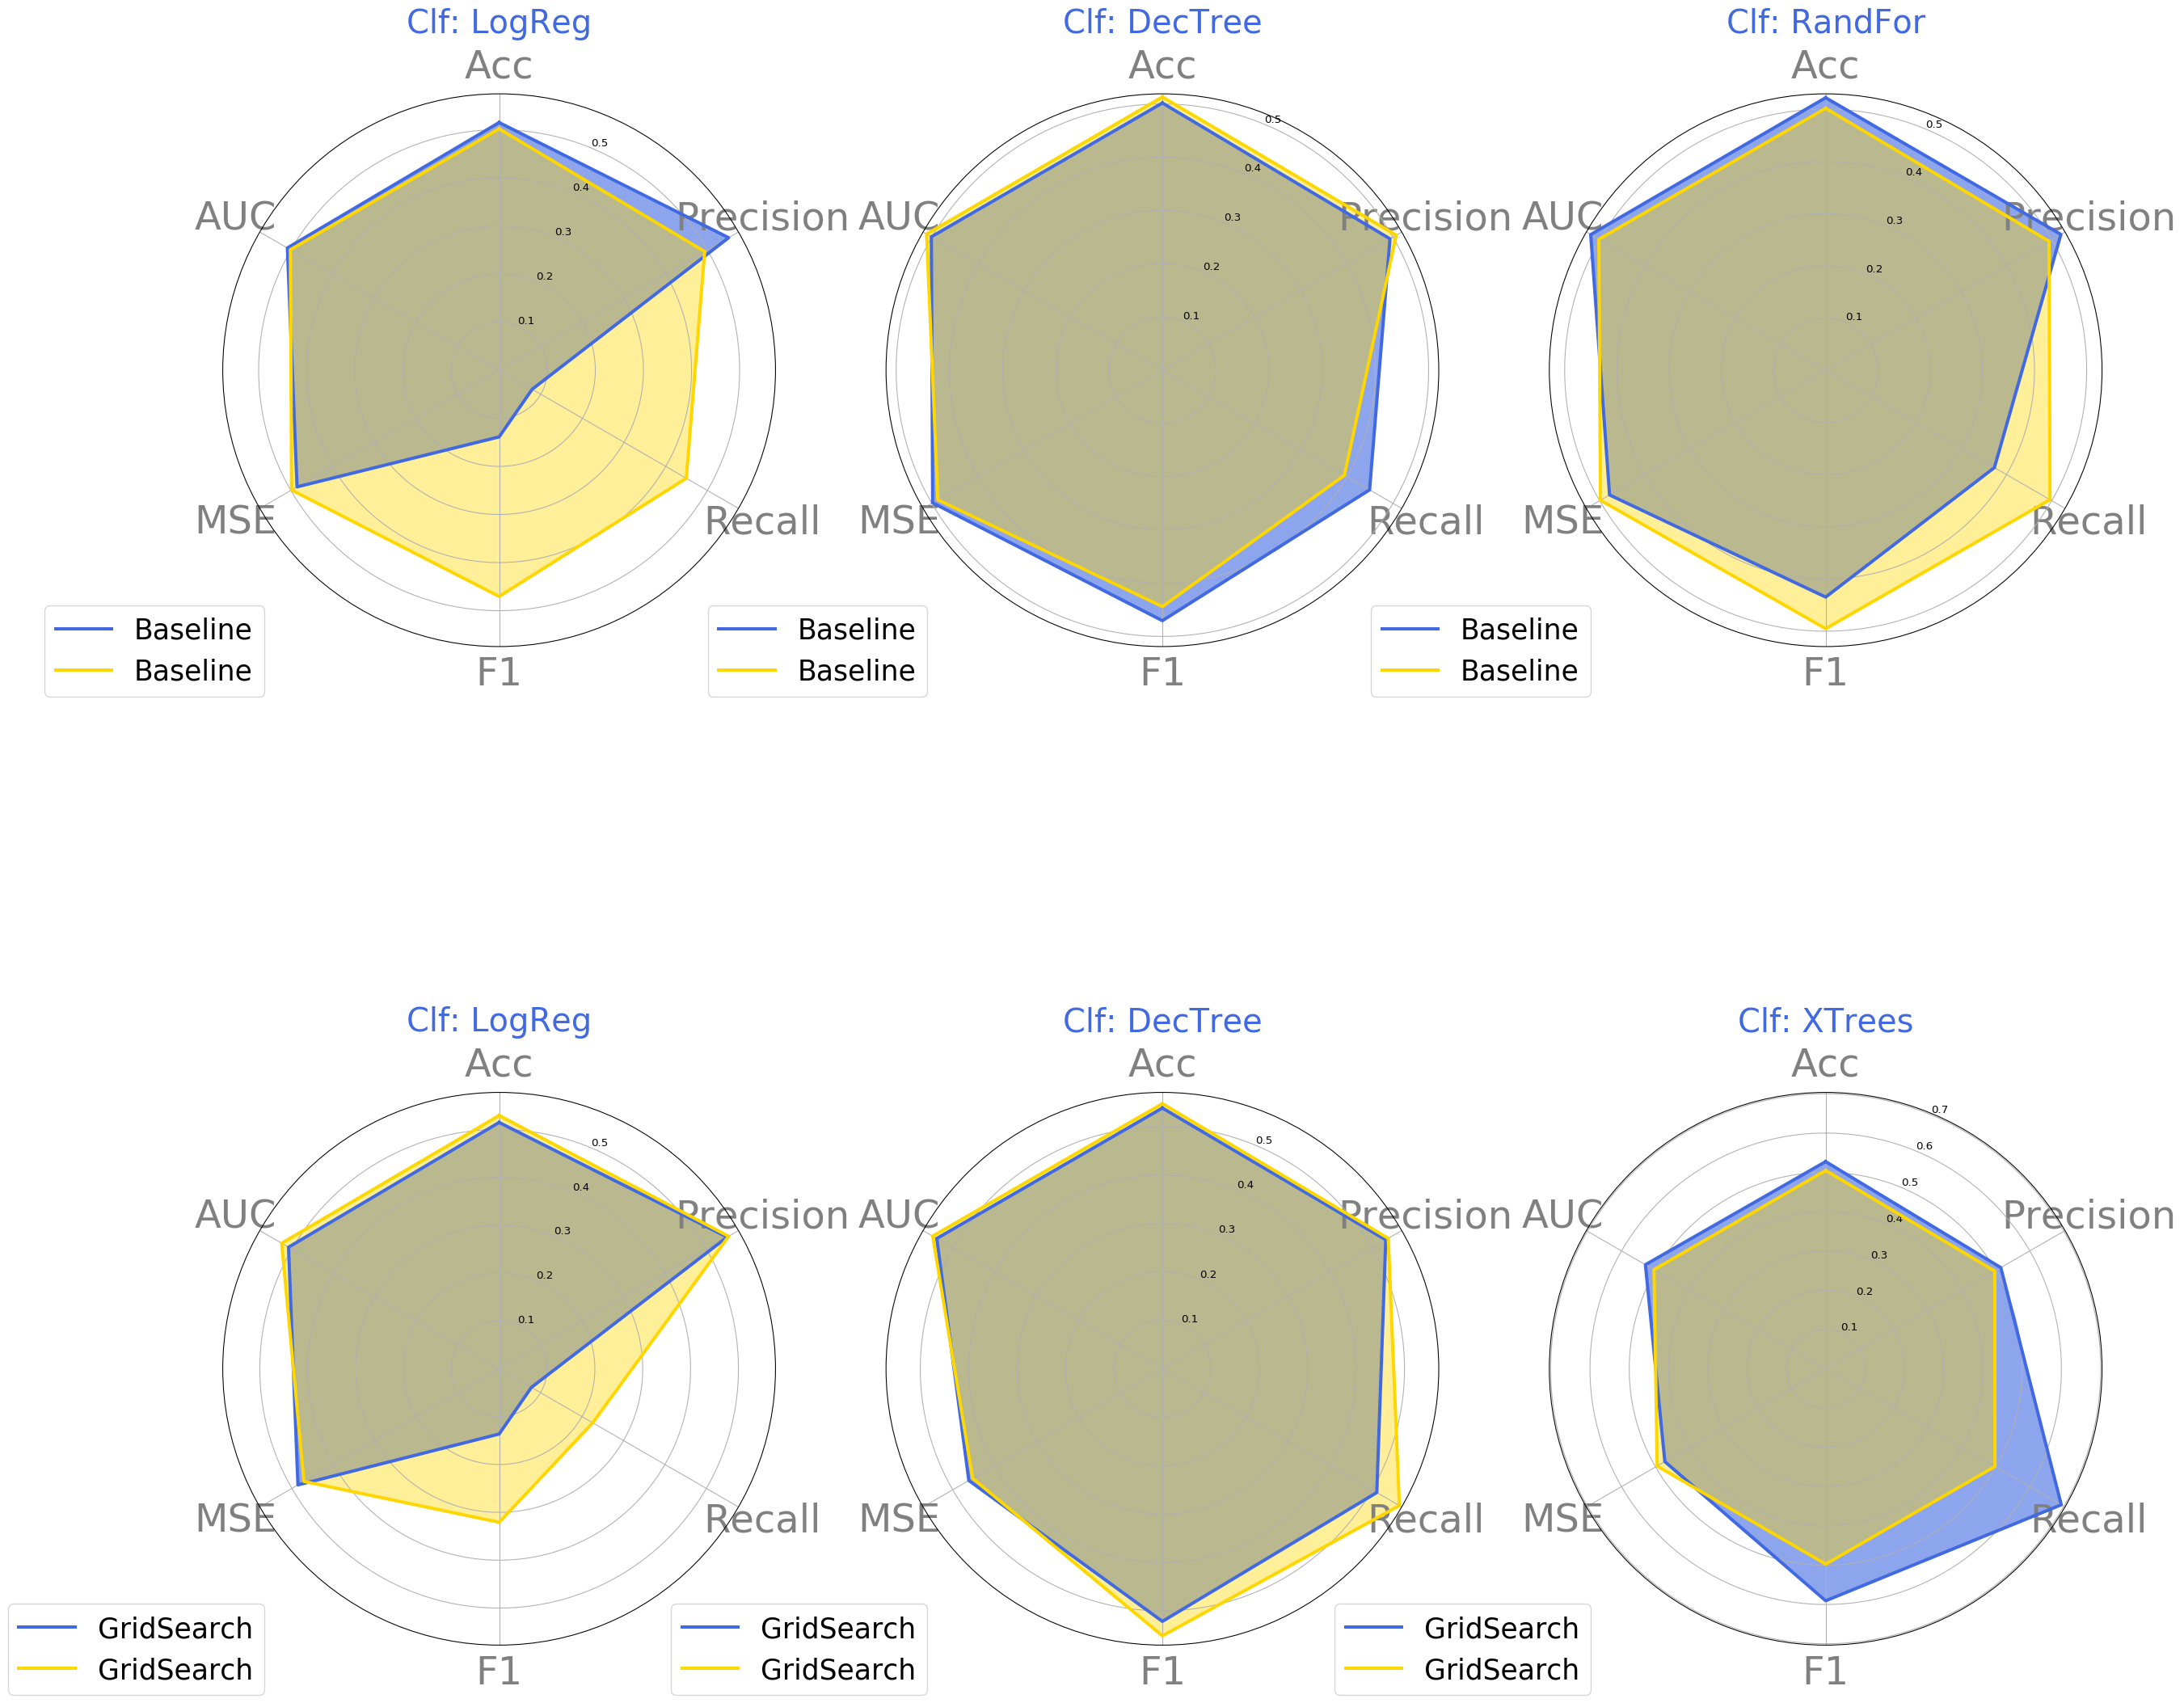

In [1296]:
df_plot = df.loc[:,feats]
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df_plot.index))
my_dpi=96
fig = plt.figure(figsize=(3000/my_dpi, 3000/my_dpi), dpi=my_dpi)

for row in range(0, len(df_plot.index), 2):
     make_spider( row=row, title='Clf: ' + df_plot['Algos'][row], color=my_palette(row))

    
fig.savefig('ClfBaselineVSGridSearch2008.png', dpi=fig.dpi)

We dont need the parameters anymore

In [178]:
# df = df.loc[df.modes=='GridSearch', ['Algos','Acc','Precision','Recall','F1','AUC','MSE']]
# df.set_index('Algos', inplace=True)
# df['score'] = df.apply(lambda row: (row.Acc+row.AUC+row.F1)/row.MSE, axis=1)
# df.sort_values(['score','Acc','AUC','F1','Precision','Recall'], ascending=False)
df_score = get_score(df)
df_score.sort_values(['score','Acc','AUC','F1','Precision','Recall'], ascending=False)

,Algos,modes,Acc,Precision,Recall,F1,MSE,AUC,score
9,XTrees,GridSearch,0.529038,0.531174,0.961970,0.684426,0.470962,0.500512,0.100363
0,DecTree,GridSearch,0.521788,0.540300,0.665370,0.596348,0.478212,0.512328,0.065276
5,RandFor,GridSearch,0.518748,0.536915,0.680200,0.600123,0.481252,0.508110,0.061075
2,KNN,Baseline,0.503235,0.532775,0.522722,0.527701,0.496765,0.501951,0.014197
11,KNN,GridSearch,0.500624,0.528825,0.544820,0.536704,0.499376,0.497711,0.012304
3,LogReg,GridSearch,0.489905,0.518588,0.546876,0.532357,0.510095,0.486151,-0.007291
4,LogReg,Baseline,0.487099,0.516149,0.542031,0.528774,0.512901,0.483479,-0.013117
6,RandFor,Baseline,0.495401,0.532263,0.408781,0.462420,0.504599,0.501108,-0.018289
10,XTrees,Baseline,0.493491,0.530038,0.405477,0.459465,0.506509,0.499290,-0.022427
8,SGD,GridSearch,0.480901,0.511337,0.501652,0.506448,0.519099,0.479534,-0.030138


In [180]:
df.set_index(['Algos','modes']).score.sort_values(ascending=False)

Algos    modes     
XTrees   GridSearch    0.100363
DecTree  GridSearch    0.065276
RandFor  GridSearch    0.061075
KNN      Baseline      0.014197
         GridSearch    0.012304
LogReg   GridSearch   -0.007291
         Baseline     -0.013117
RandFor  Baseline     -0.018289
XTrees   Baseline     -0.022427
SGD      GridSearch   -0.030138
         Baseline     -0.037676
DecTree  Baseline     -0.037676
Name: score, dtype: float64

---


# Ensemble strategies

In [186]:
import pandas as pd
def input_res(inp, idx, df, year):
    results = list(map(float, inp))
    df.loc[idx] = results
    name = 'data/EnsembleResults' + year + '.csv'
    df.to_csv(name)
    return df

In [184]:
df_clf = df.loc[df.modes == 'GridSearch',['Algos','Acc','Precision','Recall','F1','MSE','AUC']].copy()
# Rearrange columns
# cols = df_clf.columns.tolist()

# cols[-2],cols[-1] = cols[-1],cols[-2] 

# df_clf = df_clf[cols]

df_clf.set_index('Algos', inplace=True)

df_clf

,Acc,Precision,Recall,F1,MSE,AUC
Algos,,,,,,
DecTree,0.521788,0.540300,0.665370,0.596348,0.478212,0.512328
LogReg,0.489905,0.518588,0.546876,0.532357,0.510095,0.486151
RandFor,0.518748,0.536915,0.680200,0.600123,0.481252,0.508110
SGD,0.480901,0.511337,0.501652,0.506448,0.519099,0.479534
XTrees,0.529038,0.531174,0.961970,0.684426,0.470962,0.500512
KNN,0.500624,0.528825,0.544820,0.536704,0.499376,0.497711


In [187]:
# Add the voting results
# Hard vote
inp = '''0.525374	0.53541	0.801483	0.641969	0.474626	0.507181'''.split('\t')
df_clf = input_res(inp, 'HVote:XT,DT,RF', df_clf, '2008')

In [189]:
# test = pd.read_csv('data/EnsembleResults2008.csv')
# test

In [190]:
# Soft Vote
inp = '''0.523854	0.541137	0.678438	0.602059	0.476146	0.513668'''.split('\t')
df_clf = input_res(inp, 'SVote:XT,DT,RF', df_clf, '2008')

# Bagging


In [6]:
# N_EST = 500 MAX_SAMPLES= 1.0
#70s
df_clf.loc['BagSGD-54170'] = [0.552901,0.532064,0.74227,0.61983,0.447099,0.556239]
# 481 s
df_clf.loc['BagDT-5874'] = [0.524361	0.548113	0.592981	0.569665	0.475639	0.519839]
# 6 min: 
df_clf.loc['BagRF-54814'] = [0.550045,0.531628,0.703014,0.605426,0.449955,0.552742]

In [15]:
df_clf.drop('score', inplace=True, axis=1)

In [29]:
#Pasting LR: 451 s
inp = '''0.552568	0.533926	0.698653	0.605282	0.447432	0.555143'''.split('\t')
df_clf = input_res(inp, 'PastLR', df_clf)

In [31]:
#Pasting RF: 1535 s !!! 
inp = '''0.531293	0.514592	0.801590	0.626800	0.468707	0.536058'''.split('\t')
df_clf = input_res(inp, 'PastRF', df_clf)

# Boosting

In [ ]:
# Adaboost default 61 s
inp = '''0.531293	0.514592	0.801590	0.626800	0.468707	0.536058'''.split('\t')
df_clf = input_res(inp, 'AdaBoostDef', df_clf)

---

---

# Dimension reduction and Feature Selection

---

In [539]:
def get_best_features(r):
    n_cols = ['Feature', 'Acc', 'Precision', 'Recall', 'F1', 'MSE', 'AUC', 'Year']#.split('\t')

    # Initialize dataframe

    df = pd.DataFrame(columns=n_cols)
    # Fill info
    for i,r1 in enumerate(r.split('\n')):
        df.loc[i] = r1.split('\t')


    df[['Acc', 'Precision', 'Recall', 'F1', 'MSE', 'AUC']] = df[['Acc', 'Precision', 'Recall', 'F1', 'MSE', 'AUC']].apply(pd.to_numeric) 
    # Take the mean value:
    df['score'] = df.apply(lambda row: np.mean([row.Acc,row.F1,row.AUC]), axis=1)

    feats = df.loc[(df.score>0)&(df.MSE<0)].sort_values(['score','Acc','F1','AUC'], ascending=False).Feature.values


    bFeats = []
    for b in feats:
        bFeats.append(b[1:-2])
        
    return bFeats    

---
## Feature importance

paste my_res below: 

In [691]:
results = '''close_X	0.003736	0.002315	-0.007185	-0.001170	-0.003948	0.003502	-0.005997	-0.003000	0.279489	0.116321	0.006070	0.000873	-0.005997	-0.003000	0.279489	0.116321	0.006070	0.000873	0.000379	0.000446	-0.000511	-0.000065	-0.000389	0.000369	-0.006091	-0.007168	-0.014244	-0.010947	0.006252	-0.006181
companyCount_mean_X	0.001601	0.000912	0.008120	0.003584	-0.001692	0.001741	-0.003598	-0.001233	0.272719	0.113740	0.003642	0.003052	-0.003598	-0.001233	0.272719	0.113740	0.003642	0.003052	0.007476	0.008840	0.011560	0.010296	-0.007664	0.007522	-0.003655	-0.004399	0.011228	0.004036	0.003751	-0.003490
companyCount_median_X	0.001815	0.001042	0.008152	0.003678	-0.001918	0.001951	-0.003680	-0.001345	0.257334	0.105908	0.003725	0.002601	-0.003680	-0.001345	0.257334	0.105908	0.003725	0.002601	0.001896	0.002267	0.012582	0.007807	-0.001944	0.002015	-0.004710	-0.005657	0.007828	0.001614	0.004835	-0.004572
dow_X	0.002162	0.001252	0.008507	0.003941	-0.002284	0.002298	-0.002753	-0.000768	0.234710	0.095123	0.002787	0.002962	-0.002753	-0.000768	0.234710	0.095123	0.002787	0.002962	0.006393	0.007525	0.006195	0.006815	-0.006553	0.006391	0.000812	0.000985	0.022713	0.012746	-0.000834	0.001054
firstMentionSentence_median_X	0.001681	0.000957	0.008539	0.003768	-0.001777	0.001829	-0.004880	-0.002177	0.273950	0.113886	0.004938	0.001831	-0.004880	-0.002177	0.273950	0.113886	0.004938	0.001831	0.008425	0.009898	0.006770	0.008228	-0.008636	0.008406	0.003249	0.003869	0.008854	0.006546	-0.003334	0.003311
firstMentionSentence_std_X	0.001708	0.000976	0.008249	0.003672	-0.001805	0.001849	-0.004007	-0.001605	0.249568	0.101919	0.004056	0.002095	-0.004007	-0.001605	0.249568	0.101919	0.004056	0.002095	0.007124	0.008356	0.003768	0.005909	-0.007303	0.007087	-0.001326	-0.001590	0.009945	0.004624	0.001362	-0.001202
novelty_max_X	0.001761	0.001008	0.008378	0.003740	-0.001861	0.001904	-0.000654	0.000997	0.282214	0.119767	0.000662	0.006153	-0.000654	0.000997	0.282214	0.119767	0.000662	0.006153	0.002736	0.003223	0.002746	0.002969	-0.002805	0.002736	-0.002030	-0.002452	0.016489	0.007787	0.002084	-0.001825
novelty_median_X	0.001601	0.000912	0.008120	0.003584	-0.001692	0.001741	-0.000763	0.000818	0.266887	0.111833	0.000772	0.005678	-0.000763	0.000818	0.266887	0.111833	0.000772	0.005678	0.002736	0.003217	0.001022	0.002045	-0.002805	0.002717	0.000920	0.001110	0.017772	0.010108	-0.000945	0.001107
novelty_std_X	0.001788	0.001024	0.008442	0.003774	-0.001890	0.001931	-0.002426	-0.000391	0.267855	0.111697	0.002455	0.004079	-0.002426	-0.000391	0.267855	0.111697	0.002455	0.004079	0.003061	0.003592	-0.000128	0.001607	-0.003138	0.003026	-0.005387	-0.006424	-0.000064	-0.003006	0.005530	-0.005328
relevance_median_X	0.001681	0.000961	0.008055	0.003591	-0.001777	0.001818	0.000082	0.001298	0.247253	0.102315	-0.000083	0.006030	0.000082	0.001298	0.247253	0.102315	-0.000083	0.006030	0.007287	0.008523	0.001405	0.004731	-0.007470	0.007221	-0.004358	-0.005210	0.003465	-0.000543	0.004474	-0.004272
relevance_std_X	0.001361	0.000770	0.007379	0.003219	-0.001438	0.001490	-0.001827	-0.000028	0.253231	0.104559	0.001848	0.004312	-0.001827	-0.000028	0.253231	0.104559	0.001848	0.004312	0.003792	0.004469	0.004215	0.004334	-0.003888	0.003797	-0.002003	-0.002418	0.016297	0.007698	0.002056	-0.001801
returnsClosePrevMktres1_X	0.016359	0.009799	-0.050556	-0.011647	-0.017289	0.014922	0.004716	0.004237	0.215251	0.088635	-0.004773	0.009783	0.004716	0.004237	0.215251	0.088635	-0.004773	0.009783	0.006474	0.007583	0.001788	0.004494	-0.006637	0.006422	-0.000893	-0.001074	0.013859	0.006983	0.000917	-0.000730
returnsClosePrevMktres10_X	0.030023	0.017067	-0.104817	-0.024644	-0.031729	0.027126	0.005234	0.004698	0.225566	0.093716	-0.005297	0.010537	0.005234	0.004698	0.225566	0.093716	-0.005297	0.010537	0.004063	0.004842	0.013923	0.009717	-0.004165	0.004173	0.001976	0.002361	0.010330	0.006647	-0.002028	0.002069
returnsOpenPrevMktres1_X	0.001735	0.000992	0.008313	0.003706	-0.001833	0.001876	-0.004089	-0.001563	0.283181	0.118968	0.004138	0.002824	-0.004089	-0.001563	0.283181	0.118968	0.004138	0.002824	0.001463	0.001734	0.005301	0.003644	-0.001500	0.001505	0.003330	0.003944	0.003593	0.003756	-0.003418	0.003333
returnsOpenPrevMktres10_X	0.001708	0.000976	0.008313	0.003696	-0.001805	0.001850	-0.001636	0.000260	0.281189	0.118861	0.001655	0.005171	-0.001636	0.000260	0.281189	0.118861	0.001655	0.005171	0.009102	0.010740	0.011624	0.011213	-0.009330	0.009130	-0.008609	-0.010220	-0.008341	-0.009212	0.008836	-0.008606
sentenceCount_std_X	0.000801	0.000447	0.004994	0.002129	-0.000846	0.000891	-0.002862	-0.000737	0.261583	0.108353	0.002897	0.003502	-0.002862	-0.000737	0.261583	0.108353	0.002897	0.003502	0.001029	0.001213	0.000958	0.001077	-0.001055	0.001029	0.004088	0.004904	0.017002	0.011424	-0.004196	0.004231
sentimentClass_median_X	0.001334	0.000757	0.006928	0.003043	-0.001410	0.001455	-0.000709	0.000866	0.268118	0.112480	0.000717	0.005761	-0.000709	0.000866	0.268118	0.112480	0.000717	0.005761	0.006122	0.007288	0.015967	0.011946	-0.006276	0.006231	-0.003492	-0.004221	0.015655	0.006528	0.003585	-0.003280
sentimentNegative_mean_X	0.001735	0.000992	0.008313	0.003706	-0.001833	0.001876	0.000164	0.001445	0.260089	0.108742	-0.000166	0.006419	0.000164	0.001445	0.260089	0.108742	-0.000166	0.006419	0.006637	0.007895	0.015967	0.012226	-0.006803	0.006740	-0.001705	-0.002040	0.007635	0.003167	0.001751	-0.001602
sentimentNegative_std_X	0.001868	0.001070	0.008861	0.003959	-0.001974	0.002018	-0.003435	-0.001134	0.266829	0.110793	0.003476	0.003069	-0.003435	-0.001134	0.266829	0.110793	0.003476	0.003069	0.008506	0.009975	0.005110	0.007380	-0.008719	0.008468	-0.005929	-0.007142	0.009303	0.001737	0.006085	-0.005760
sentimentNeutral_mean_X	0.001735	0.000992	0.008313	0.003706	-0.001833	0.001876	-0.000027	0.001294	0.258125	0.107683	0.000028	0.006186	-0.000027	0.001294	0.258125	0.107683	0.000028	0.006186	0.003711	0.004355	0.000447	0.002270	-0.003804	0.003675	0.003628	0.004344	0.014693	0.009916	-0.003723	0.003750
sentimentNeutral_std_X	0.001014	0.000554	0.007862	0.003263	-0.001072	0.001161	-0.002508	-0.000590	0.236175	0.095924	0.002538	0.003236	-0.002508	-0.000590	0.236175	0.095924	0.002538	0.003236	-0.004090	-0.004814	-0.006770	-0.005859	0.004193	-0.004120	-0.001408	-0.001680	0.005582	0.002224	0.001445	-0.001330
sentimentPositive_mean_X	0.001735	0.000992	0.008313	0.003706	-0.001833	0.001876	-0.003053	-0.000852	0.267415	0.111236	0.003090	0.003456	-0.003053	-0.000852	0.267415	0.111236	0.003090	0.003456	-0.000217	-0.000256	-0.000319	-0.000290	0.000222	-0.000218	0.004034	0.004852	0.019569	0.012792	-0.004140	0.004205
sentimentPositive_std_X	0.001628	0.000925	0.008539	0.003748	-0.001720	0.001776	-0.002263	-0.000311	0.259473	0.107517	0.002290	0.004036	-0.002263	-0.000311	0.259473	0.107517	0.002290	0.004036	0.008316	0.009872	0.016159	0.013242	-0.008525	0.008403	-0.003276	-0.003932	0.008982	0.003030	0.003362	-0.003140
sentimentWordCount_median_X	0.001494	0.000847	0.008023	0.003507	-0.001579	0.001635	-0.002235	-0.000276	0.262902	0.109256	0.002262	0.004146	-0.002235	-0.000276	0.262902	0.109256	0.002262	0.004146	0.000731	0.000855	-0.003641	-0.001543	-0.000750	0.000683	0.006118	0.007424	0.030540	0.019946	-0.006280	0.006388
sentimentWordCount_std_X	0.000694	0.000374	0.005832	0.002395	-0.000733	0.000804	-0.001172	0.000487	0.261202	0.108799	0.001186	0.005142	-0.001172	0.000487	0.261202	0.108799	0.001186	0.005142	-0.003549	-0.004208	0.002938	-0.000376	0.003638	-0.003476	-0.000433	-0.000517	0.007507	0.003798	0.000445	-0.000345
universe_X	0.002002	0.001153	0.008603	0.003915	-0.002115	0.002143	-0.007088	-0.003814	0.233098	0.092714	0.007173	-0.001307	-0.007088	-0.003814	0.233098	0.092714	0.007173	-0.001307	-0.001923	-0.002292	0.013923	0.006441	0.001972	-0.001747	-0.005550	-0.006598	-0.003272	-0.004813	0.005696	-0.005524
urgency_mean_X	0.000987	0.000534	0.008313	0.003419	-0.001044	0.001145	-0.000981	0.000583	0.254052	0.105287	0.000993	0.005156	-0.000981	0.000583	0.254052	0.105287	0.000993	0.005156	0.002465	0.002919	0.006451	0.004810	-0.002527	0.002509	-0.002030	-0.002438	0.011036	0.004827	0.002084	-0.001886
volume_X	0.001548	0.000879	0.008120	0.003563	-0.001636	0.001689	-0.001963	-0.000082	0.262052	0.108930	0.001986	0.004391	-0.001963	-0.000082	0.262052	0.108930	0.001986	0.004391	0.003657	0.004304	0.002874	0.003540	-0.003749	0.003648	-0.003546	-0.004265	0.010651	0.003783	0.003640	-0.003389
volumeCounts_max_X	0.001575	0.000896	0.007991	0.003526	-0.001664	0.001712	-0.002753	-0.000569	0.281980	0.118849	0.002787	0.004099	-0.002753	-0.000569	0.281980	0.118849	0.002787	0.004099	0.005499	0.006472	0.005046	0.005710	-0.005637	0.005494	0.002842	0.003416	0.017195	0.010847	-0.002918	0.003001
volumeCounts_min_X	0.001708	0.000975	0.008345	0.003708	-0.001805	0.001851	-0.001772	-0.000028	0.245289	0.100651	0.001793	0.004174	-0.001772	-0.000028	0.245289	0.100651	0.001793	0.004174	0.006176	0.007289	0.008303	0.007831	-0.006331	0.006200	-0.004413	-0.005307	0.009560	0.002714	0.004529	-0.004258
wordCount_median_X	0.001468	0.000830	0.008055	0.003509	-0.001551	0.001609	-0.006979	-0.003733	0.287167	0.119954	0.007063	0.000100	-0.006979	-0.003733	0.287167	0.119954	0.007063	0.000100	0.001219	0.001442	0.003449	0.002516	-0.001250	0.001244	-0.000920	-0.001107	0.013923	0.007003	0.000945	-0.000756'''

In [692]:
n_cols = ['Metrix','LogReg Acc', 'LogReg Precision', 'LogReg Recall', 'LogReg F1',
       'LogReg MSE', 'LogReg AUC', 'SGD Acc', 'SGD Precision',
       'SGD Recall', 'SGD F1', 'SGD MSE', 'SGD AUC', 'DecTree Acc',
       'DecTree Precision', 'DecTree Recall', 'DecTree F1', 'DecTree MSE',
       'DecTree AUC', 'XTrees Acc', 'XTrees Precision', 'XTrees Recall',
       'XTrees F1', 'XTrees MSE', 'XTrees AUC', 'RandFor Acc',
       'RandFor Precision', 'RandFor Recall', 'RandFor F1', 'RandFor MSE',
       'RandFor AUC']#.split('\t')
df = pd.DataFrame(columns=n_cols)
# Fill info
for i,r1 in enumerate(results.split('\n')):
    df.loc[i] = r1.split('\t')
df.set_index('Metrix', inplace=True)

df = df.apply(pd.to_numeric) 

Q1 or q2? 

In [693]:
df.to_csv('data/Feature_importance_Q1.csv')

Join all the feature importances

In [694]:
def get_feature_importances(quarter):
    # quarter = 'Q3'
    df = pd.read_csv('data/Feature_importance_'+quarter+'.csv', index_col = 'Metrix')

    best_feats = pd.DataFrame()
    mt = ['SGD','DecTree', 'XTrees', 'RandFor','LogReg']

    for m in mt:

        topFeats = df.loc[(df[m +' Acc']>0)&(df[m+' F1']>0)&(df[m+' AUC']>0),df.columns.str.startswith(m)].sort_values([m+' Acc',m+' AUC',m+' F1'], ascending=False).index.values

        tf = pd.DataFrame(topFeats, columns = [m])
        tf.reset_index(inplace=True)
        tf.set_index(m, inplace=True)
        tf.index.name = 'features'
        tf.rename(columns={'index':m+'_'+quarter}, inplace=True)

        best_feats = pd.merge(best_feats, tf, right_index=True, left_index=True, how='outer')
    # Get rid of the _X
    best_feats.reset_index(inplace=True)
    best_feats['features'] = best_feats.features.apply(lambda x: x[:-2])
    best_feats.set_index('features', inplace=True)
    
    return best_feats

In [900]:
bf = pd.merge(get_feature_importances('Q2'), get_feature_importances('Q3'), right_index=True, left_index=True, how='outer')
bf = pd.merge(get_feature_importances('Q1'), bf, right_index=True, left_index=True, how='outer')

bf.head()

,SGD_Q1,DecTree_Q1,XTrees_Q1,RandFor_Q1,LogReg_Q1,SGD_Q2,DecTree_Q2,XTrees_Q2,RandFor_Q2,LogReg_Q2,SGD_Q3,DecTree_Q3,XTrees_Q3,RandFor_Q3,LogReg_Q3
features,,,,,,,,,,,,,,,
close,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
companyCount_mean,NaN,NaN,4.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN
companyCount_median,NaN,NaN,21.0,NaN,3.0,NaN,NaN,NaN,6.0,NaN,2.0,2.0,NaN,5.0,NaN
dow,NaN,NaN,9.0,9.0,0.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
firstMentionSentence_median,NaN,NaN,2.0,5.0,13.0,3.0,3.0,NaN,15.0,NaN,NaN,NaN,NaN,2.0,NaN


In [729]:
# Add the forest importances

In [895]:
F1 = [['returnsOpenPrevMktres10', 0.05903369184766274],
       ['close', 0.02228636895781712],
       ['returnsClosePrevMktres1', 0.015866231806465576],
       ['returnsClosePrevMktres10', 0.02149620410459919],
       ['returnsOpenPrevMktres1', 0.020043461116334246],
       ['volume', 0.01615501122012622],
       ['sentimentWordCount_median', 0.01686517288425073],
       ['sentimentNegative_mean', 0.015544985552403611],
       ['sentimentPositive_mean', 0.012581751697534296],
       ['sentimentNeutral_mean', 0.024150026849089113],
       ['wordCount_median', 0.01792722590157517]]
F2 = [['returnsOpenPrevMktres10', 0.057656204420422366],
 ['returnsClosePrevMktres10', 0.023290818809443902],
 ['close', 0.015878684769846614],
 ['returnsClosePrevMktres1', 0.020647291194883486],
 ['returnsOpenPrevMktres1', 0.019318183009237423],
 ['volume', 0.017130871386100015],
 ['sentimentPositive_mean', 0.018120948547137996],
 ['sentimentNeutral_mean', 0.016147165942006707],
 ['sentimentNegative_mean', 0.013617569308061189],
 ['wordCount_median', 0.022482822390726832],
 ['sentimentWordCount_median', 0.018481600476974745]]

F3 = [['returnsOpenPrevMktres10', 0.05819967814151069],
 ['returnsClosePrevMktres10', 0.02303286089227373], 
 ['close', 0.01760634284875675], 
 ['returnsClosePrevMktres1', 0.021434615424369082], 
 ['returnsOpenPrevMktres1', 0.018255097661587776], 
 ['volume', 0.016205238171314675], 
 ['sentimentNeutral_mean', 0.018107527089701553], 
 ['sentimentPositive_mean', 0.016578692036007033], 
 ['sentimentNegative_mean', 0.01527055080604619], 
 ['sentimentWordCount_median', 0.020307859725066664], 
 ['wordCount_median', 0.01693718040164885]]

In [747]:
s = []
for i,f in enumerate(F1):
    s.append(f[0])
ForesFeat_Q1 = pd.DataFrame(s)
ForesFeat_Q1.reset_index(inplace=True)
ForesFeat_Q1.rename(columns = {'index':'ForesFeat_Q1', 0:'features'}, inplace=True)
ForesFeat_Q1.set_index('features', inplace=True)

In [897]:
s = []
for i,f in enumerate(F1):
    s.append(f[0])
ForesFeat_Q2 = pd.DataFrame(s)
ForesFeat_Q2.reset_index(inplace=True)
ForesFeat_Q2.rename(columns = {'index':'ForesFeat_Q2', 0:'features'}, inplace=True)
ForesFeat_Q2.set_index('features', inplace=True)

In [752]:
s = []
for i,f in enumerate(F3):
    s.append(f[0])
ForesFeat_Q3 = pd.DataFrame(s)
ForesFeat_Q3.reset_index(inplace=True)
ForesFeat_Q3.rename(columns = {'index':'ForesFeat_Q3', 0:'features'}, inplace=True)
ForesFeat_Q3.set_index('features', inplace=True)

In [901]:
bf = pd.merge(bf, ForesFeat_Q1, right_index=True, left_index=True, how='outer')
bf = pd.merge(bf, ForesFeat_Q3, right_index=True, left_index=True, how='outer')
bf = pd.merge(bf, ForesFeat_Q2, right_index=True, left_index=True, how='outer')

In [902]:
bf

,SGD_Q1,DecTree_Q1,XTrees_Q1,RandFor_Q1,LogReg_Q1,SGD_Q2,DecTree_Q2,XTrees_Q2,RandFor_Q2,LogReg_Q2,SGD_Q3,DecTree_Q3,XTrees_Q3,RandFor_Q3,LogReg_Q3,ForesFeat_Q1,ForesFeat_Q3,ForesFeat_Q2
features,,,,,,,,,,,,,,,,,,
close,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0
companyCount_mean,NaN,NaN,4.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN
companyCount_median,NaN,NaN,21.0,NaN,3.0,NaN,NaN,NaN,6.0,NaN,2.0,2.0,NaN,5.0,NaN,NaN,NaN,NaN
dow,NaN,NaN,9.0,9.0,0.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
firstMentionSentence_median,NaN,NaN,2.0,5.0,13.0,3.0,3.0,NaN,15.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
firstMentionSentence_std,NaN,NaN,6.0,NaN,12.0,1.0,1.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN
novelty_max,NaN,NaN,18.0,NaN,5.0,11.0,11.0,NaN,11.0,6.0,NaN,NaN,NaN,19.0,8.0,NaN,NaN,NaN
novelty_median,NaN,NaN,19.0,8.0,17.0,NaN,NaN,NaN,7.0,7.0,NaN,NaN,NaN,1.0,9.0,NaN,NaN,NaN
novelty_std,NaN,NaN,17.0,NaN,4.0,6.0,6.0,NaN,NaN,4.0,4.0,4.0,NaN,17.0,7.0,NaN,NaN,NaN


In [903]:
bf.to_csv('data/feature_sets.csv')

---
Classifiers metrics vs feature sets

In [3]:
import pandas as pd

In [4]:
results = '''LogReg	(218781, 31)	4.186683	0.512917	0.503806	0.855225	0.634081	0.487083	0.517337	Baseline Q1
SGD	(218781, 31)	0.335306	0.504196	0.498300	0.696224	0.580864	0.495804	0.506675	Baseline Q1
DecTree	(218781, 31)	1.117346	0.504196	0.498300	0.696224	0.580864	0.495804	0.506675	Baseline Q1
XTrees	(218781, 31)	6.821496	0.502633	0.495452	0.431350	0.461184	0.497367	0.501712	Baseline Q1
RandFor	(218781, 31)	14.026948	0.508515	0.502334	0.430600	0.463709	0.491485	0.507509	Baseline Q1
LogReg	(218781, 20)	1.485419	0.512615	0.503547	0.873899	0.638935	0.487385	0.517280	_XTrees_Q1
SGD	(218781, 20)	0.254120	0.502976	0.497644	0.762942	0.602376	0.497024	0.506332	_XTrees_Q1
DecTree	(218781, 20)	0.711589	0.502976	0.497644	0.762942	0.602376	0.497024	0.506332	_XTrees_Q1
XTrees	(218781, 20)	5.417348	0.503593	0.496603	0.436685	0.464721	0.496407	0.502729	_XTrees_Q1
RandFor	(218781, 20)	11.113476	0.507254	0.500832	0.435046	0.465627	0.492746	0.506321	_XTrees_Q1
LogReg	(218781, 7)	0.299109	0.493459	0.493459	1.000000	0.660827	0.506541	0.500000	RandFor_Q1
SGD	(218781, 7)	0.130383	0.493473	0.493466	1.000000	0.660833	0.506527	0.500014	RandFor_Q1
DecTree	(218781, 7)	0.264895	0.493473	0.493466	1.000000	0.660833	0.506527	0.500014	RandFor_Q1
XTrees	(218781, 7)	3.052611	0.498217	0.490733	0.446578	0.467615	0.501783	0.497551	RandFor_Q1
RandFor	(218781, 7)	7.928030	0.502866	0.495874	0.447495	0.470444	0.497134	0.502151	RandFor_Q1
LogReg	(218781, 20)	1.692049	0.494556	0.493960	0.993164	0.659775	0.505444	0.500995	LogReg_Q1
SGD	(218781, 20)	0.232528	0.499287	0.495612	0.830161	0.620676	0.500713	0.503559	LogReg_Q1
DecTree	(218781, 20)	0.678094	0.499287	0.495612	0.830161	0.620676	0.500713	0.503559	LogReg_Q1
XTrees	(218781, 20)	5.346025	0.502633	0.495555	0.441409	0.466917	0.497367	0.501842	LogReg_Q1
RandFor	(218781, 20)	11.590618	0.506623	0.500095	0.439325	0.467745	0.493377	0.505754	LogReg_Q1
LogReg	(218781, 11)	0.426246	0.513808	0.504306	0.862395	0.636439	0.486192	0.518309	ForesFeat_Q1
SGD	(218781, 11)	0.141436	0.502989	0.498110	0.948204	0.653122	0.497011	0.508738	ForesFeat_Q1
DecTree	(218781, 11)	0.655398	0.502989	0.498110	0.948204	0.653122	0.497011	0.508738	ForesFeat_Q1
XTrees	(218781, 11)	4.104500	0.506198	0.499601	0.435074	0.465110	0.493802	0.505280	ForesFeat_Q1
RandFor	(218781, 11)	12.859241	0.506527	0.499984	0.433101	0.464145	0.493473	0.505579	ForesFeat_Q1
LogReg	(265762, 31)	11.442206	0.546575	0.552573	0.654272	0.599138	0.453425	0.542576	Baseline_Q2
SGD	(265762, 31)	0.448227	0.516074	0.536784	0.478684	0.506072	0.483926	0.517463	Baseline_Q2
DecTree	(265762, 31)	1.509680	0.516074	0.536784	0.478684	0.506072	0.483926	0.517463	Baseline_Q2
XTrees	(265762, 31)	8.413601	0.502980	0.525507	0.415366	0.463990	0.497020	0.506234	Baseline_Q2
RandFor	(265762, 31)	18.223503	0.509934	0.533973	0.422406	0.471682	0.490066	0.513184	Baseline_Q2
LogReg	(265762, 12)	1.847577	0.513918	0.521063	0.759983	0.618243	0.486082	0.504781	SGD_Q2
SGD	(265762, 12)	0.183573	0.507100	0.519572	0.640802	0.573854	0.492900	0.502135	SGD_Q2
DecTree	(265762, 12)	0.443436	0.507100	0.519572	0.640802	0.573854	0.492900	0.502135	SGD_Q2
XTrees	(265762, 12)	5.099769	0.497652	0.518762	0.415235	0.461261	0.502348	0.500713	SGD_Q2
RandFor	(265762, 12)	11.488928	0.498013	0.519525	0.408871	0.457604	0.501987	0.501324	SGD_Q2
LogReg	(265762, 12)	1.843751	0.513918	0.521063	0.759983	0.618243	0.486082	0.504781	DecTree_Q2
SGD	(265762, 12)	0.184560	0.507100	0.519572	0.640802	0.573854	0.492900	0.502135	DecTree_Q2
DecTree	(265762, 12)	0.442528	0.507100	0.519572	0.640802	0.573854	0.492900	0.502135	DecTree_Q2
XTrees	(265762, 12)	5.127883	0.497652	0.518762	0.415235	0.461261	0.502348	0.500713	DecTree_Q2
RandFor	(265762, 12)	11.450499	0.498013	0.519525	0.408871	0.457604	0.501987	0.501324	DecTree_Q2
LogReg	(265762, 6)	0.651404	0.548235	0.550751	0.692916	0.613708	0.451765	0.542862	XTrees_Q2
SGD	(265762, 6)	0.142816	0.522588	0.541465	0.510462	0.525507	0.477412	0.523038	XTrees_Q2
DecTree	(265762, 6)	0.483426	0.522588	0.541465	0.510462	0.525507	0.477412	0.523038	XTrees_Q2
XTrees	(265762, 6)	3.902409	0.505667	0.528537	0.421447	0.468956	0.494333	0.508794	XTrees_Q2
RandFor	(265762, 6)	13.138186	0.507495	0.530832	0.422167	0.470304	0.492505	0.510664	XTrees_Q2
LogReg	(265762, 18)	12.798889	0.551158	0.553907	0.685092	0.612554	0.448842	0.546184	RandFor_Q2
SGD	(265762, 18)	0.279321	0.518151	0.535612	0.523518	0.529496	0.481849	0.517952	RandFor_Q2
DecTree	(265762, 18)	0.985608	0.518151	0.535612	0.523518	0.529496	0.481849	0.517952	RandFor_Q2
XTrees	(265762, 18)	6.966121	0.504075	0.526853	0.416303	0.465099	0.495925	0.507335	RandFor_Q2
RandFor	(265762, 18)	16.525836	0.509821	0.533764	0.423126	0.472049	0.490179	0.513040	RandFor_Q2
LogReg	(265762, 11)	2.182159	0.549533	0.550524	0.709394	0.619943	0.450467	0.543596	LogReg_Q2
SGD	(265762, 11)	0.185272	0.527724	0.538595	0.614712	0.574142	0.472276	0.524493	LogReg_Q2
DecTree	(265762, 11)	0.547024	0.527724	0.538595	0.614712	0.574142	0.472276	0.524493	LogReg_Q2
XTrees	(265762, 11)	5.335777	0.501885	0.523979	0.417459	0.464693	0.498115	0.505020	LogReg_Q2
RandFor	(265762, 11)	12.526920	0.507981	0.531264	0.424629	0.471999	0.492019	0.511076	LogReg_Q2
LogReg	(265762, 11)	2.062151	0.550221	0.554111	0.673496	0.607998	0.449779	0.545643	ForesFeat_Q2
SGD	(265762, 11)	0.175580	0.519032	0.542642	0.453771	0.494243	0.480968	0.521455	ForesFeat_Q2
DecTree	(265762, 11)	0.862165	0.519032	0.542642	0.453771	0.494243	0.480968	0.521455	ForesFeat_Q2
XTrees	(265762, 11)	5.323191	0.508647	0.532279	0.422668	0.471183	0.491353	0.511840	ForesFeat_Q2
RandFor	(265762, 11)	16.911964	0.511920	0.536371	0.424608	0.473990	0.488080	0.515163	ForesFeat_Q2
LogReg	(393355, 5)	0.559613	0.489990	0.522738	0.114194	0.187441	0.510010	0.501714	SGD_Q3
SGD	(393355, 5)	0.210741	0.490486	0.528130	0.102290	0.171386	0.509514	0.502597	SGD_Q3
DecTree	(393355, 5)	0.316825	0.490486	0.528130	0.102290	0.171386	0.509514	0.502597	SGD_Q3
XTrees	(393355, 5)	6.057076	0.498135	0.515730	0.422057	0.464215	0.501865	0.500509	SGD_Q3
RandFor	(393355, 5)	15.838591	0.496534	0.514203	0.409769	0.456084	0.503466	0.499241	SGD_Q3
LogReg	(393355, 5)	0.499032	0.489990	0.522738	0.114194	0.187441	0.510010	0.501714	DecTree_Q3
SGD	(393355, 5)	0.207210	0.490486	0.528130	0.102290	0.171386	0.509514	0.502597	DecTree_Q3
DecTree	(393355, 5)	0.313131	0.490486	0.528130	0.102290	0.171386	0.509514	0.502597	DecTree_Q3
XTrees	(393355, 5)	6.105139	0.498135	0.515730	0.422057	0.464215	0.501865	0.500509	DecTree_Q3
RandFor	(393355, 5)	15.852538	0.496534	0.514203	0.409769	0.456084	0.503466	0.499241	DecTree_Q3
LogReg	(393355, 2)	0.278600	0.526689	0.551380	0.435574	0.486683	0.473311	0.529532	XTrees_Q3
SGD	(393355, 2)	0.176008	0.521892	0.552068	0.380987	0.450843	0.478108	0.526288	XTrees_Q3
DecTree	(393355, 2)	0.239519	0.521892	0.552068	0.380987	0.450843	0.478108	0.526288	XTrees_Q3
XTrees	(393355, 2)	4.234838	0.501537	0.518560	0.451920	0.482952	0.498463	0.503085	XTrees_Q3
RandFor	(393355, 2)	14.283706	0.500362	0.517955	0.433709	0.472103	0.499638	0.502442	XTrees_Q3
LogReg	(393355, 26)	5.145962	0.536429	0.557685	0.483796	0.518119	0.463571	0.538071	RandFor_Q3
SGD	(393355, 26)	0.532635	0.516226	0.528507	0.564204	0.545772	0.483774	0.514729	RandFor_Q3
DecTree	(393355, 26)	1.845696	0.516226	0.528507	0.564204	0.545772	0.483774	0.514729	RandFor_Q3
XTrees	(393355, 26)	13.081735	0.503855	0.525247	0.383326	0.443202	0.496145	0.507616	RandFor_Q3
RandFor	(393355, 26)	29.818057	0.505144	0.527528	0.377064	0.439782	0.494856	0.509140	RandFor_Q3
LogReg	(393355, 14)	1.592456	0.537413	0.559232	0.481486	0.517455	0.462587	0.539157	LogReg_Q3
SGD	(393355, 14)	0.379071	0.524302	0.531534	0.645115	0.582842	0.475698	0.520533	LogReg_Q3
DecTree	(393355, 14)	1.197578	0.524302	0.531534	0.645115	0.582842	0.475698	0.520533	LogReg_Q3
XTrees	(393355, 14)	8.784048	0.504107	0.525648	0.382630	0.442879	0.495893	0.507897	LogReg_Q3
RandFor	(393355, 14)	21.729737	0.504069	0.525592	0.382660	0.442879	0.495931	0.507857	LogReg_Q3'''

In [5]:
n_cols = ['Algos','data_size','ETA','Acc','Precision','Recall','F1','MSE','AUC','Feat_set']#.split('\t')

# Initialize dataframe

df = pd.DataFrame(columns=n_cols)
# Fill info
for i,r1 in enumerate(results.split('\n')):
    df.loc[i] = r1.split('\t')


df[['Acc', 'Precision', 'Recall', 'F1', 'MSE', 'AUC']] = df[['Acc', 'Precision', 'Recall', 'F1', 'MSE', 'AUC']].apply(pd.to_numeric) 
df['score'] = df.apply(lambda row: (((row.Acc+row.F1+row.AUC-row.MSE)/3)), axis=1)
df['quarter'] = df.Feat_set.apply(lambda x: x[-2:])

fs = df.loc[(df.Acc>0.5)&(df.AUC>0.5)&(df.F1>0.5)&(df.MSE<0.5), ['Algos','Acc','Precision','Recall','F1','MSE','AUC','Feat_set','score','quarter']].sort_values(['Algos','quarter','score'], ascending=False)


In [6]:
df.shape

(85, 12)

In [7]:
fs.shape

(34, 10)

These classifiers showed an improving performance (compared to their Baseline) using most of the feature sets: 

In [8]:
a = ['SGD', 'LogReg', 'DecTree'] #fs.Algos.unique()

Are all feature sets in SGD the same in DecTrees and LogReg? (in fs)??

In [9]:

# pd.merge(fs.loc[fs.Algos==a[0],['Algos','Feat_set']], fs.loc[fs.Algos==a[1],['Algos','Feat_set']], on='Feat_set', how='left', suffixes=('SGD', 'LogReg'))
fSet = pd.merge(fs.loc[fs.Algos==a[0],['Algos','Feat_set']], fs.loc[fs.Algos==a[2],['Algos','Feat_set']], on='Feat_set', how='left', suffixes=('SGD', 'DecTree'))

What are the common features of all these feature sets?

In [11]:
bf = pd.read_csv('data/feature_sets.csv')

In [12]:
ftr = bf.loc[:,fSet.Feat_set.values]
ftr['Num'] = ftr.iloc[:,:11].count(axis=1)
ftr['means'] = ftr.iloc[:,:11].mean(axis=1)

/Users/iZbra1/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/Users/iZbra1/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


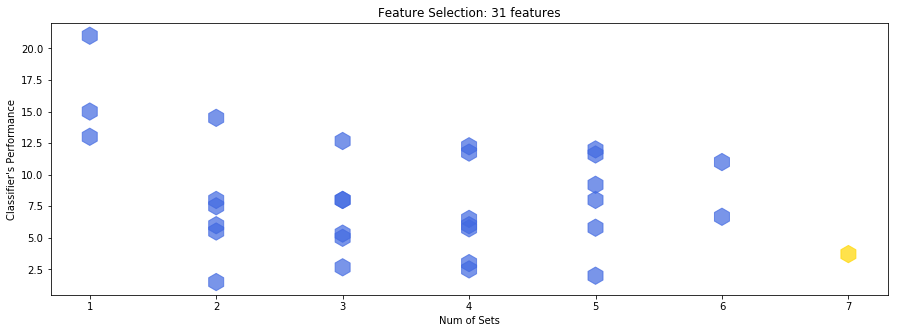

In [17]:
import matplotlib.pyplot as plt
# Ploting purposes:
ftr['colors'] = 'royalblue'
ftr.loc[ftr.Num==7,['colors']] = 'gold'

fig = plt.figure(figsize=(15,5))
plt.scatter(ftr.Num, ftr.means, c=ftr.colors, s=300, marker='h', alpha=0.7)
plt.xlabel('Num of Sets')
plt.ylabel("Classifier's Performance")
plt.title('Feature Selection: '+str(ftr.shape[0])+' features')
# plt.legend(loc='best')
plt.show()
fig.savefig('images/Unscaled Feature_selection_sets.png')

# KNN
to get a list of best features, the best being number 7 here since it appears in most feature sets and has high improving value. 

In [1061]:
import math
from operator import itemgetter

distances = []
testInstance = ftr.loc[ftr.Num==7,['Num', 'means']].values[0]
length = len(testInstance)
trainingSet = ftr.loc[(ftr.Num!=7),['Num', 'means']].values
k = len(trainingSet)

for x in range(len(trainingSet)):
#x=1
# -- Get euclidean Distance

    instance1 = testInstance
    instance2 = trainingSet[x]
    distance = 0
    for x in range(length):
        distance += math.pow((instance1[x]-instance2[x]), 2)
    dist = math.sqrt(distance)
    distances.append((instance2,dist))

# -- Get the k nearest     

distances.sort(key=itemgetter(1))  # sort by the 1-nth element 
neighbors = []
for x in range(k):
    neighbors.append(distances[x][0])

topF = pd.DataFrame([ftr.loc[(ftr.Num==neigh[0])&(ftr.means==neigh[1])].index.values[0] 
                     for neigh in neighbors], columns=['top_features'])

# find dupes
dupes = pd.concat(g for _, g in topF.groupby("top_features") if len(g) > 1).top_features.values
dupes

array(['dow', 'dow'], dtype=object)

In [1064]:
#dow corresponds to 3,8
# Correct it
topF.loc[17,'top_features'] = ftr.loc[(ftr.Num==3)&(ftr.means==8.0)].index.values[1]

The **top 16 features** showed the best performance in the set of classifiers

In [1424]:
topF.index.name = 'Importance'
topF
topF['Type'] = pd.Series(['Market', 'Market','News','News','Market','News','News','Market','News','News','Market','News',
                'News','Market','News','News','F.Engineered', 'News', 'News', 'News', 'News', 'News', 'News', 'News', 'News', 'News', 'News', 'News', 'News', 'News'], index=topF.index)


How many features belong to the news? 

In [1509]:
topF.iloc[:16].groupby('Type').count()/16*100

,top_features
Type,
Market,37.5
News,62.5


In [1430]:
topF.iloc[:16, 0].values

array(['returnsOpenPrevMktres10', 'returnsClosePrevMktres10',
       'firstMentionSentence_std', 'sentimentNeutral_mean',
       'returnsOpenPrevMktres1', 'firstMentionSentence_median',
       'novelty_median', 'volume', 'relevance_median',
       'sentimentNeutral_std', 'universe', 'novelty_std',
       'companyCount_median', 'close', 'sentimentNegative_std',
       'sentimentWordCount_median'], dtype=object)

The figure below shows the performance of four of the best features.

In [ ]:
# Unscaled: 
f1_T = data.loc[data.target==True, ['returnsOpenPrevMktres10','returnsClosePrevMktres10','firstMentionSentence_std','sentimentNeutral_mean']]
f1_F = data.loc[data.target==False, ['returnsOpenPrevMktres10','returnsClosePrevMktres10','firstMentionSentence_std','sentimentNeutral_mean']]
# Standardized:

f1_T = pd.DataFrame(StandardScaler().fit_transform(f1_T.values), columns= ['returnsOpenPrevMktres10','returnsClosePrevMktres10','firstMentionSentence_std','sentimentNeutral_mean'])
f1_F = pd.DataFrame(StandardScaler().fit_transform(f1_F.values), columns= ['returnsOpenPrevMktres10','returnsClosePrevMktres10','firstMentionSentence_std','sentimentNeutral_mean'])

f = plt.figure(figsize=(20, 12))
plt.subplot(411)
ax = sns.distplot( f1_T.iloc[:,0] , color="royalblue", label="Feature 1 True", hist=False,
                  kde_kws={"shade": True, "alpha":0.6})
ax = sns.distplot( f1_F.iloc[:,0] , color="gold", label="Feature 1 False", hist=False,
                  kde_kws={"shade": True, "alpha":1, "linewidth": 5})
ax.xaxis.set_visible(False)
plt.legend(loc='upper right', fancybox=True, fontsize='x-large')


plt.subplot(412)
ax = sns.distplot( f1_T.iloc[:,1] , color="royalblue", label="Feature 2 True", hist=False,
                  kde_kws={"shade": True, "alpha":0.5})
ax = sns.distplot( f1_F.iloc[:,1] , color="gold", label="Feature 2 False", hist=False,
                  kde_kws={"shade": True, "alpha":0.5, "linewidth": 4})
ax.xaxis.set_visible(False)
plt.legend(loc='upper right', fancybox=True, fontsize='x-large')

plt.subplot(413)
ax= sns.distplot( f1_T.iloc[:,2] , color="royalblue", label="Feature 3 True", hist=False, 
                  kde_kws={"shade": True, "alpha":0.6, "linewidth":4})
ax = sns.distplot( f1_F.iloc[:,2] , color="gold", label="Feature 3 False", hist=False,
                  kde_kws={"shade": True, "alpha":0.4, "linewidth":4})
ax.xaxis.set_visible(False)
plt.legend(loc='upper right', fancybox=True, fontsize='x-large')

plt.subplot(414)
ax = sns.distplot( f1_T.iloc[:,3] , color="royalblue", label="Feature 4 True", hist=False,
                  kde_kws={"shade": True, "alpha":0.6})
ax = sns.distplot( f1_F.iloc[:,3] , color="gold", label="Feature 4 False", hist=False,
                  kde_kws={"shade": True, "alpha":0.4})
ax.xaxis.set_visible(False)
plt.legend(loc='upper right', fancybox=True, fontsize='x-large')

plt.show()

---

## Feature set selection

In [1207]:
fts = '''LogReg	(878147, 16)	5.783929	0.525790	0.518775	0.704626	0.597584	0.474210	0.525898	Baseline_F16_kernel3
SGD	(878147, 16)	1.169805	0.514646	0.510514	0.696785	0.589280	0.485354	0.514756	Baseline_F16_kernel3
DecTree	(878147, 16)	3.064497	0.514646	0.510514	0.696785	0.589280	0.485354	0.514756	Baseline_F16_kernel3
XTrees	(878147, 16)	31.513141	0.508042	0.509634	0.409588	0.454166	0.491958	0.507982	Baseline_F16_kernel3
RandFor	(878147, 16)	76.810160	0.510245	0.512380	0.411714	0.456564	0.489755	0.510186	Baseline_F16_kernel3
LogReg	(878147, 23)	14.828011	0.503686	0.502147	0.791391	0.614431	0.496314	0.503861	Baseline_F24_kernel5
SGD	(878147, 23)	1.256000	0.499368	0.499370	0.742673	0.597191	0.500632	0.499516	Baseline_F24_kernel5
DecTree	(878147, 23)	3.869431	0.499368	0.499370	0.742673	0.597191	0.500632	0.499516	Baseline_F24_kernel5
LogReg	(878147, 19)	11.694534	0.503570	0.502024	0.810602	0.620042	0.496430	0.503757	Baseline_F20_kernel6
SGD	(878147, 19)	1.307513	0.500605	0.500197	0.763614	0.604453	0.499395	0.500765	Baseline_F20_kernel6
DecTree	(878147, 19)	3.366271	0.500605	0.500197	0.763614	0.604453	0.499395	0.500765	Baseline_F20_kernel6
LogReg	(878147, 14)	5.939053	0.502084	0.501075	0.830149	0.624939	0.497916	0.502283	Baseline_F14
SGD	(878147, 14)	1.108037	0.501466	0.500767	0.758616	0.603295	0.498534	0.501622	Baseline_F14
DecTree	(878147, 14)	2.597269	0.501466	0.500767	0.758616	0.603295	0.498534	0.501622	Baseline_F14
LogReg	(878147, 15)	8.935219	0.502016	0.501034	0.830039	0.624876	0.497984	0.502215	Baseline_F15
SGD	(878147, 15)	2.062631	0.501647	0.500891	0.755621	0.602435	0.498353	0.501801	Baseline_F15
DecTree	(878147, 15)	4.007538	0.501647	0.500891	0.755621	0.602435	0.498353	0.501801	Baseline_F15
LogReg	(878147, 17)	9.252398	0.502484	0.501353	0.807902	0.618740	0.497516	0.502669	Baseline_F18
SGD	(878147, 17)	1.318737	0.501117	0.500521	0.781922	0.610348	0.498883	0.501288	Baseline_F18
DecTree	(878147, 17)	3.112895	0.501117	0.500521	0.781922	0.610348	0.498883	0.501288	Baseline_F18
LogReg	(878147, 16)	8.977596	0.502531	0.501383	0.808162	0.618839	0.497469	0.502717	Baseline_F16_best
SGD	(878147, 16)	1.354291	0.501138	0.500532	0.784903	0.611262	0.498862	0.501310	Baseline_F16_best
DecTree	(878147, 16)	3.071642	0.501138	0.500532	0.784903	0.611262	0.498862	0.501310	Baseline_F16_best
LogReg	(878147, 18)	7.681223	0.525755	0.518892	0.699472	0.595800	0.474245	0.525861	Last
SGD	(878147, 18)	1.280559	0.516197	0.512339	0.660270	0.576974	0.483803	0.516284	Last
DecTree	(878147, 18)	3.219729	0.516197	0.512339	0.660270	0.576974	0.483803	0.516284	Last
LogReg	(878147, 17)	7.146644	0.525708	0.518858	0.699376	0.595742	0.474292	0.525813	Alpha
SGD	(878147, 17)	1.304540	0.515332	0.511367	0.676493	0.582453	0.484668	0.515430	Alpha
DecTree	(878147, 17)	3.089633	0.515332	0.511367	0.676493	0.582453	0.484668	0.515430	Alpha
LogReg	(878147, 16)	6.378531	0.525605	0.518774	0.699547	0.595749	0.474395	0.525711	Beta Kernel7
SGD	(878147, 16)	1.249082	0.513757	0.509793	0.700743	0.590208	0.486243	0.513871	Beta Kernel7
DecTree	(878147, 16)	2.959628	0.513757	0.509793	0.700743	0.590208	0.486243	0.513871	Beta Kernel7
LogReg	(878147, 16)	5.825221	0.525790	0.518775	0.704626	0.597584	0.474210	0.525898	K3
SGD	(878147, 16)	1.114081	0.514646	0.510514	0.696785	0.589280	0.485354	0.514756	K3
DecTree	(878147, 16)	3.107975	0.514646	0.510514	0.696785	0.589280	0.485354	0.514756	K3'''

In [1208]:
n_cols = ['Algos','data_size','ETA','Acc','Precision','Recall','F1','MSE','AUC','Feat_set']#.split('\t')
# Initialize dataframe

df = pd.DataFrame(columns=n_cols)
# Fill info
for i,r1 in enumerate(fts.split('\n')):
    df.loc[i] = r1.split('\t')


df[['Acc', 'Precision', 'Recall', 'F1', 'MSE', 'AUC']] = df[['Acc', 'Precision', 'Recall', 'F1', 'MSE', 'AUC']].apply(pd.to_numeric) 
df['score'] = df.apply(lambda row: (((row.Acc+row.F1+row.AUC-row.MSE)/3)), axis=1)

fs = df.loc[(df.Acc>0.5)&(df.AUC>0.5)&(df.F1>0.5)&(df.MSE<0.5), ['Algos','data_size','Acc','Precision','Recall','F1','MSE','AUC','Feat_set','score']].sort_values(['Algos','score'], ascending=False)


In [1211]:
fs.loc[fs.Feat_set=='K3'].sort_values(['Algos', 'score'], ascending=False)

,Algos,data_size,Acc,Precision,Recall,F1,MSE,AUC,Feat_set,score
33,SGD,"(878147, 16)",0.514646,0.510514,0.696785,0.589280,0.485354,0.514756,K3,0.377776
32,LogReg,"(878147, 16)",0.525790,0.518775,0.704626,0.597584,0.474210,0.525898,K3,0.391687
34,DecTree,"(878147, 16)",0.514646,0.510514,0.696785,0.589280,0.485354,0.514756,K3,0.377776


---

# PCA

In [1253]:
results = '''LogReg	(878147, 9)	2.192869	0.525649	0.518381	0.715126	0.601063	0.474351	0.525766	Baseline_PCA9
SGD	(878147, 9)	1.179397	0.515329	0.510981	0.699435	0.590537	0.484671	0.515442	Baseline_PCA9
DecTree	(878147, 9)	3.332207	0.515329	0.510981	0.699435	0.590537	0.484671	0.515442	Baseline_PCA9
LogReg	(878147, 8)	1.797138	0.525974	0.518576	0.716965	0.601843	0.474026	0.526091	Baseline_PCA8
SGD	(878147, 8)	1.078182	0.518017	0.513078	0.695203	0.590415	0.481983	0.518126	Baseline_PCA8
DecTree	(878147, 8)	3.006154	0.518017	0.513078	0.695203	0.590415	0.481983	0.518126	Baseline_PCA8
LogReg	(878147, 7)	2.489883	0.502309	0.501113	0.901947	0.644274	0.497691	0.502555	Baseline_PCA7
SGD	(878147, 7)	1.019677	0.501852	0.500918	0.842843	0.628379	0.498148	0.502061	Baseline_PCA7
DecTree	(878147, 7)	2.613841	0.501852	0.500918	0.842843	0.628379	0.498148	0.502061	Baseline_PCA7
LogReg	(878147, 6)	2.271453	0.500543	0.500123	0.962049	0.658120	0.499457	0.500827	Baseline_PCA6
SGD	(878147, 6)	0.914114	0.498948	0.499248	0.903178	0.643042	0.501052	0.499196	Baseline_PCA6
DecTree	(878147, 6)	2.237022	0.498948	0.499248	0.903178	0.643042	0.501052	0.499196	Baseline_PCA6
LogReg	(878147, 5)	2.072460	0.500540	0.500121	0.961994	0.658106	0.499460	0.500823	Baseline_PCA5
SGD	(878147, 5)	0.865954	0.498415	0.498954	0.903321	0.642835	0.501585	0.498664	Baseline_PCA5
DecTree	(878147, 5)	1.895385	0.498415	0.498954	0.903321	0.642835	0.501585	0.498664	Baseline_PCA5
LogReg	(878147, 4)	1.783695	0.500102	0.499894	0.969323	0.659615	0.499898	0.500391	Baseline_PCA4
SGD	(878147, 4)	0.758724	0.498241	0.498852	0.898481	0.641520	0.501759	0.498487	Baseline_PCA4
DecTree	(878147, 4)	1.507421	0.498241	0.498852	0.898481	0.641520	0.501759	0.498487	Baseline_PCA4
LogReg	(878147, 16)	6.367452	0.525772	0.518767	0.704365	0.597484	0.474228	0.525882	Baseline_PCA16
SGD	(878147, 16)	1.391812	0.515038	0.510931	0.688989	0.586749	0.484962	0.515145	Baseline_PCA16
DecTree	(878147, 16)	5.045695	0.515038	0.510931	0.688989	0.586749	0.484962	0.515145	Baseline_PCA16
LogReg	(878147, 14)	5.072310	0.525790	0.518508	0.714312	0.600861	0.474210	0.525905	Baseline_PCA14
SGD	(878147, 14)	1.283679	0.516753	0.512195	0.691135	0.588361	0.483247	0.516861	Baseline_PCA14
DecTree	(878147, 14)	4.724502	0.516753	0.512195	0.691135	0.588361	0.483247	0.516861	Baseline_PCA14
LogReg	(878147, 13)	4.719949	0.525762	0.518463	0.715221	0.601152	0.474238	0.525879	Baseline_PCA13
SGD	(878147, 13)	1.246441	0.516569	0.512001	0.694198	0.589339	0.483431	0.516678	Baseline_PCA13
DecTree	(878147, 13)	4.343435	0.516569	0.512001	0.694198	0.589339	0.483431	0.516678	Baseline_PCA13
LogReg	(878147, 12)	4.483835	0.525786	0.518481	0.715221	0.601164	0.474214	0.525903	Baseline_PCA12
SGD	(878147, 12)	1.230840	0.518246	0.513474	0.684053	0.586614	0.481754	0.518348	Baseline_PCA12
DecTree	(878147, 12)	4.450320	0.518246	0.513474	0.684053	0.586614	0.481754	0.518348	Baseline_PCA12
LogReg	(878147, 11)	2.589831	0.525564	0.518369	0.713184	0.600368	0.474436	0.525679	Baseline_PCA11
SGD	(878147, 11)	1.190052	0.516805	0.512419	0.681092	0.584837	0.483195	0.516906	Baseline_PCA11
DecTree	(878147, 11)	4.023215	0.516805	0.512419	0.681092	0.584837	0.483195	0.516906	Baseline_PCA11
LogReg	(878147, 10)	2.389993	0.525704	0.518438	0.714551	0.600898	0.474296	0.525820	Baseline_PCA10
SGD	(878147, 10)	1.132586	0.516439	0.511723	0.704577	0.592861	0.483561	0.516555	Baseline_PCA10
DecTree	(878147, 10)	3.687869	0.516439	0.511723	0.704577	0.592861	0.483561	0.516555	Baseline_PCA10'''

In [1254]:
import re
n_cols = ['Algos','data_size','ETA','Acc','Precision','Recall','F1','MSE','AUC','Method']#.split('\t')
# Initialize dataframe

df = pd.DataFrame(columns=n_cols)
# Fill info
for i,r1 in enumerate(results.split('\n')):
    df.loc[i] = r1.split('\t')


df[['Acc', 'Precision', 'Recall', 'F1', 'MSE', 'AUC']] = df[['Acc', 'Precision', 'Recall', 'F1', 'MSE', 'AUC']].apply(pd.to_numeric) 
df['score'] = df.apply(lambda row: ((row.Acc+row.F1+row.AUC)/3+1-row.MSE)*0.5, axis=1)
df['Method'] = df.Method.apply(lambda x: int(re.search(r"\d{1,2}$", x).group(0)))
df.head()

,Algos,data_size,ETA,Acc,Precision,Recall,F1,MSE,AUC,Method,score
0,LogReg,"(878147, 9)",2.192869,0.525649,0.518381,0.715126,0.601063,0.474351,0.525766,9,0.538237
1,SGD,"(878147, 9)",1.179397,0.515329,0.510981,0.699435,0.590537,0.484671,0.515442,9,0.527883
2,DecTree,"(878147, 9)",3.332207,0.515329,0.510981,0.699435,0.590537,0.484671,0.515442,9,0.527883
3,LogReg,"(878147, 8)",1.797138,0.525974,0.518576,0.716965,0.601843,0.474026,0.526091,8,0.538638
4,SGD,"(878147, 8)",1.078182,0.518017,0.513078,0.695203,0.590415,0.481983,0.518126,8,0.530102


In [1282]:
X = df.loc[df.Algos=='LogReg', ['Method','score']].sort_values('Method').values
Y = df.loc[df.Algos=='SGD', ['Method','score']].sort_values('Method').values
Z = df.loc[df.Algos=='DecTree', ['Method','score']].sort_values('Method').values

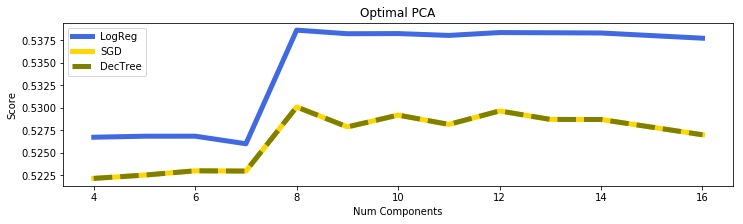

In [1287]:
fig = plt.figure(figsize=(12,3))
# Same, but add a stronger line on top (edge)
# plt.fill_between( X[:,0], X[:,1], color="skyblue", alpha=0.2)
plt.plot(X[:,0], X[:,1], color="royalblue", linewidth=5, label='LogReg')
plt.plot(Y[:,0], Y[:,1], color="gold", linewidth=5, label='SGD')
plt.plot(Z[:,0], Z[:,1], color="olive", linewidth=5, label='DecTree', linestyle='--')
# See the line plot function to learn how to customize the plt.plot function
plt.xlabel('Num Components')
plt.ylabel('Score')
plt.title('Optimal PCA')
plt.legend(loc='best')
plt.show()
fig.savefig('images/OptimalPCA.png', dpi=fig.dpi)

LDA or PCA? 

In [1497]:
results = '''LogReg	(878147, 8)	1.797138	0.525974	0.518576	0.716965	0.601843	0.474026	0.526091	PCA8
SGD	(878147, 8)	1.078182	0.518017	0.513078	0.695203	0.590415	0.481983	0.518126	PCA8
DecTree	(878147, 8)	3.006154	0.518017	0.513078	0.695203	0.590415	0.481983	0.518126	PCA8
LogReg	(878147, 1)	0.628099	0.525684	0.518761	0.702115	0.596670	0.474316	0.525792	LDA
SGD	(878147, 1)	0.378337	0.521468	0.513852	0.785462	0.621268	0.478532	0.521630	LDA
DecTree	(878147, 1)	0.410978	0.521468	0.513852	0.785462	0.621268	0.478532	0.521630	LDA
LogReg	(878147, 16)	5.825221	0.525790	0.518775	0.704626	0.597584	0.474210	0.525898	Baseline
SGD	(878147, 16)	1.114081	0.514646	0.510514	0.696785	0.589280	0.485354	0.514756	Baseline
DecTree	(878147, 16)	3.107975	0.514646	0.510514	0.696785	0.589280	0.485354	0.514756	Baseline'''

In [1498]:
import re
n_cols = ['Algos','data_size','ETA','Acc','Precision','Recall','F1','MSE','AUC','Method']#.split('\t')
# Initialize dataframe

df1 = pd.DataFrame(columns=n_cols)
# Fill info
for i,r1 in enumerate(results.split('\n')):
    df1.loc[i] = r1.split('\t')


df1[['Acc', 'Precision', 'Recall', 'F1', 'MSE', 'AUC']] = df1[['Acc', 'Precision', 'Recall', 'F1', 'MSE', 'AUC']].apply(pd.to_numeric) 
df1['score'] = df1.apply(lambda row: ((row.Acc+row.F1+row.AUC)/3+1-row.MSE)*0.5, axis=1)
# Order index
df1.set_index('Algos', inplace=True)
df1.sort_index(inplace=True)
df1.reset_index(inplace=True)
df1['Label'] = df1.Algos+'_'+df1.Method
df1.sort_values(['Algos','score'], ascending=False)

,Algos,data_size,ETA,Acc,Precision,Recall,F1,MSE,AUC,Method,score,Label
7,SGD,"(878147, 1)",0.378337,0.521468,0.513852,0.785462,0.621268,0.478532,0.521630,LDA,0.538128,SGD_LDA
6,SGD,"(878147, 8)",1.078182,0.518017,0.513078,0.695203,0.590415,0.481983,0.518126,PCA8,0.530102,SGD_PCA8
8,SGD,"(878147, 16)",1.114081,0.514646,0.510514,0.696785,0.589280,0.485354,0.514756,Baseline,0.527103,SGD_Baseline
3,LogReg,"(878147, 8)",1.797138,0.525974,0.518576,0.716965,0.601843,0.474026,0.526091,PCA8,0.538638,LogReg_PCA8
5,LogReg,"(878147, 16)",5.825221,0.525790,0.518775,0.704626,0.597584,0.474210,0.525898,Baseline,0.537774,LogReg_Baseline
4,LogReg,"(878147, 1)",0.628099,0.525684,0.518761,0.702115,0.596670,0.474316,0.525792,LDA,0.537533,LogReg_LDA
1,DecTree,"(878147, 1)",0.410978,0.521468,0.513852,0.785462,0.621268,0.478532,0.521630,LDA,0.538128,DecTree_LDA
0,DecTree,"(878147, 8)",3.006154,0.518017,0.513078,0.695203,0.590415,0.481983,0.518126,PCA8,0.530102,DecTree_PCA8
2,DecTree,"(878147, 16)",3.107975,0.514646,0.510514,0.696785,0.589280,0.485354,0.514756,Baseline,0.527103,DecTree_Baseline


In [1499]:
dfs  = df1.loc[:,['MSE','AUC','score','Acc','Precision','Recall','F1','Label']].copy()

In [1506]:
dfs.Label

0        DecTree_PCA8
1         DecTree_LDA
2    DecTree_Baseline
3         LogReg_PCA8
4          LogReg_LDA
5     LogReg_Baseline
6            SGD_PCA8
7             SGD_LDA
8        SGD_Baseline
Name: Label, dtype: object

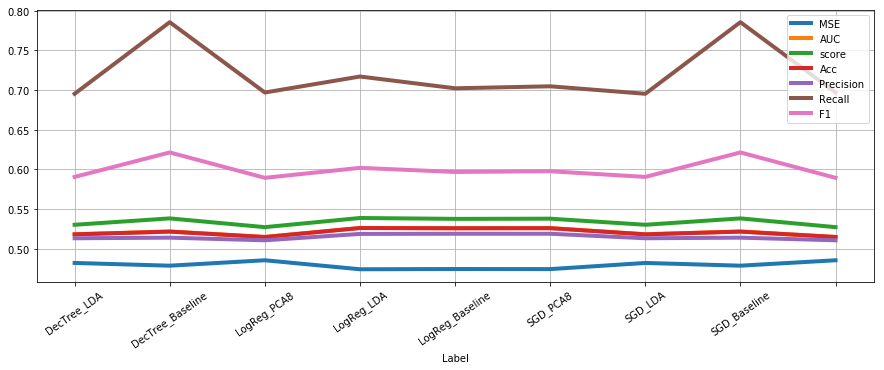

In [1507]:

#plt.plot( 'Method', 'MSE', data=dfs, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4, label='MSE')
ax = dfs.plot(x='Label', y=['MSE','AUC','score','Acc','Precision','Recall','F1'],
              linewidth=4, figsize=(15,5))
ax.set_xticklabels(dfs.Label, rotation=35)
ax.grid()
plt.show()

DecTree and SGD with LDA and Logreg with PCA8 - Comparisson with Gridsearch


In [1486]:
results = '''SGD	2007-2016	(878147, 8)	1.063498	0.518017	0.513078	0.695203	0.590415	0.481983	0.518126	FALSE	PCA
SGD	2007-2016	(878147, 1)	0.447058	0.521468	0.513852	0.785462	0.621268	0.478532	0.521630	FALSE	LDA
SGD	2007-2016	(878147, 1)	54.440854	0.523193	0.515717	0.751381	0.611634	0.476807	0.523333	TRUE	LDA
SGD	2007-2016	(878147, 1)	451.440805	0.525615	0.518780	0.699545	0.595752	0.474385	0.525722	TRUE	LDA
SGD	2007-2016	(878147, 16)	1136.872533	0.525960	0.517893	0.743028	0.610362	0.474040	0.526092	TRUE	Baseline
LR	2007-2016	(878147, 1)	0.733668	0.525684	0.518761	0.702115	0.596670	0.474316	0.525792	FALSE	LDA
LR	2007-2016	(878147, 1)	31.201768	0.525813	0.519214	0.689666	0.592423	0.474187	0.525914	TRUE	LDA
LR	2007-2016	(878147, 8)	1.901290	0.525974	0.518576	0.716965	0.601843	0.474026	0.526091	FALSE	PCA
LR	2007-2016	(878147, 8)	76.633096	0.526302	0.519100	0.706928	0.598626	0.473698	0.526413	TRUE	PCA
LR	2007-2016	(878147, 16)	151.170591	0.526411	0.519240	0.704996	0.598025	0.473589	0.526520	TRUE	Baseline
DT	2007-2016	(878147, 16)	2164.920768	0.536260	0.530986	0.616542	0.570574	0.463740	0.536309	TRUE	Baseline
DT	2007-2016	(878147, 1)	56.841492	0.527118	0.522736	0.616792	0.565883	0.472882	0.527174	TRUE	LDA
DT	2007-2016	(878147, 1)	0.485242	0.521468	0.513852	0.785462	0.621268	0.478532	0.521630	FALSE	LDA
DT	2007-2016	(878147, 8)	3.077187	0.518017	0.513078	0.695203	0.590415	0.481983	0.518126	FALSE	PCA
RF	2007-2016	(878147, 16)	2501.959547	0.537705	0.532761	0.608598	0.568160	0.462295	0.537749	TRUE	Baseline
RF	2007-2016	(878147, 1)	1493.819791	0.527105	0.522635	0.619110	0.566797	0.472895	0.527161	TRUE	LDA
RF	2007-2016	(878147, 16)	3614.66609	0.537166	0.532148	0.610496	0.568636	0.462834	0.537211	TRUE	Baseline
XT	2007-2016	(878147, 1)	659.837340	0.525878	0.519274	0.689331	0.592339	0.474122	0.525979	TRUE	LDA
XT	2007-2016	(878147, 16)	1446.593219	0.503358	0.501662	0.922663	0.649943	0.496642	0.503613	TRUE	Baseline
XT	2007-2016	(878147, 1)	2695.358952	0.526555	0.521517	0.636564	0.573326	0.473445	0.526622	TRUE	LDA'''

In [1488]:
n_cols = ['Algos','year','data_size','ETA','Acc','Precision','Recall','F1','MSE','AUC','Optimal','Method']#.split('\t')
# Initialize dataframe

df1 = pd.DataFrame(columns=n_cols)
# Fill info
for i,r1 in enumerate(results.split('\n')):
    df1.loc[i] = r1.split('\t')


df1[['Acc', 'Precision', 'Recall', 'F1', 'MSE', 'AUC']] = df1[['Acc', 'Precision', 'Recall', 'F1', 'MSE', 'AUC']].apply(pd.to_numeric) 
df1['score'] = df1.apply(lambda row: ((row.Acc+row.F1+row.AUC)/3+1-row.MSE)*0.5, axis=1)
# Order index
df1.set_index('Algos', inplace=True)
df1.sort_index(inplace=True)
df1.reset_index(inplace=True)
df1.loc[:,['Algos','Acc','Precision','Recall','F1','MSE','AUC','score','Optimal','Method']].sort_values(['Algos','score'], ascending=False)



,Algos,Acc,Precision,Recall,F1,MSE,AUC,score,Optimal,Method
17,XT,0.525878,0.519274,0.689331,0.592339,0.474122,0.525979,0.536972,TRUE,LDA
19,XT,0.526555,0.521517,0.636564,0.573326,0.473445,0.526622,0.534361,TRUE,LDA
18,XT,0.503358,0.501662,0.922663,0.649943,0.496642,0.503613,0.527831,TRUE,Baseline
13,SGD,0.525960,0.517893,0.743028,0.610362,0.474040,0.526092,0.540049,TRUE,Baseline
16,SGD,0.521468,0.513852,0.785462,0.621268,0.478532,0.521630,0.538128,FALSE,LDA
15,SGD,0.523193,0.515717,0.751381,0.611634,0.476807,0.523333,0.537956,TRUE,LDA
14,SGD,0.525615,0.518780,0.699545,0.595752,0.474385,0.525722,0.537322,TRUE,LDA
12,SGD,0.518017,0.513078,0.695203,0.590415,0.481983,0.518126,0.530102,FALSE,PCA
11,RF,0.537705,0.532761,0.608598,0.568160,0.462295,0.537749,0.542788,TRUE,Baseline
9,RF,0.537166,0.532148,0.610496,0.568636,0.462834,0.537211,0.542418,TRUE,Baseline


Selecting the best score of each classifier, the veredict is: 

In [1406]:
clf1 = SGDClassifier(random_state=42, 
                     alpha=0.01, 
                     l1_ratio=0.25, 
                     loss='log', 
                     penalty='elasticnet')
# --> fit(X_train, y_train)

clf2 = LogisticRegression(random_state=42)
# --> fit(X_triain_pca, y_train)

clf3 = DecisionTreeClassifier(random_state=42, 
                              max_leaf_nodes=91, 
                              min_samples_leaf=7,
                              min_weight_fraction_leaf=0.01)
# --> fit(X_train, y_train)

clf4 = RandomForestClassifier(random_state=42, 
                              max_leaf_nodes=93,
                              min_samples_leaf=1,
                              min_samples_split=11,
                              n_estimators=43)
# --> fit(X_train_lda, y_train)

clf5 = ExtraTreesClassifier(random_state=42, 
                            max_leaf_nodes=97, 
                            min_samples_leaf=2,
                            min_samples_split=9,
                            n_estimators=47)
# --> fit(X_train_lda, y_train)

Comparison between the best classifiers:

In [1490]:
x = df1.loc[[12,9,7,3,17], 
        ['Algos','ETA','Acc','Precision','Recall','F1','MSE','AUC','Optimal','Method','score']]\
        .sort_values(['score','AUC','Acc','F1'], ascending=False).reset_index()
x.drop('index', axis=1, inplace=True)

x.sort_values('score', ascending=False)
x.Algos = ['RandomForest', 'LogisticRegression', 'XTrees','DecisionTrees','SGD'] 

ax = x.plot(x.index,['score','Acc','F1','AUC','MSE'], figsize=(15,5), linewidth=4, marker='p')
ax.grid()
ax.legend(loc='lower left')
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(x.Algos)
ax.set_title('Optimal Classifiers-set performance metrics')
plt.show()
fig.savefig('images/ClassifierSet.png')

In [ ]:
# Create data frame. The last column is the needed color
df = pd.DataFrame(np.random.random((100,2)), columns=["x","y"])
 
# Add a column: the color depends of x and y values, but you can use whatever function.
value=(df['x']>0.2) & (df['y']>0.4)
df['color']= np.where( value==True , "#9b59b6", "#3498db")
 
# plot
sns.regplot(data=df, x="x", y="y", fit_reg=False, scatter_kws={'facecolors':df['color']})
#sns.plt.show()


Spider Plot

In [1345]:
def plot_spider(df1, row, title):
    categories = list(filter(lambda s: not s.startswith(('Method','Algos')), df1))
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] 
    ax = plt.subplot(2,3,(row//2)+1, polar=True, )
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=36)

    legend_label = df1.loc[row,'Method']
    values=df1.loc[row].drop(['Algos','Method']).values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values,color='royalblue', linewidth=4, linestyle='solid', label=legend_label)
    ax.fill(angles, values, 'royalblue', alpha=0.2)

    legend_label = df1.loc[row+1,'Method']
    values=df1.loc[row+1].drop(['Algos','Method']).values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='limegreen',linewidth=3, linestyle='solid', label=legend_label)
    ax.fill(angles, values, 'limegreen', alpha=0.8)

    legend_label = df1.loc[row+2,'Method']
    values=df1.loc[row+1].drop(['Algos','Method']).values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='firebrick',linewidth=4, linestyle='solid', label=legend_label)
    ax.fill(angles, values, 'firebrick', alpha=0.2)

    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), prop={'size': 26})
    # Add a title
    plt.title(title, size=30, color='royalblue', y=1.1)

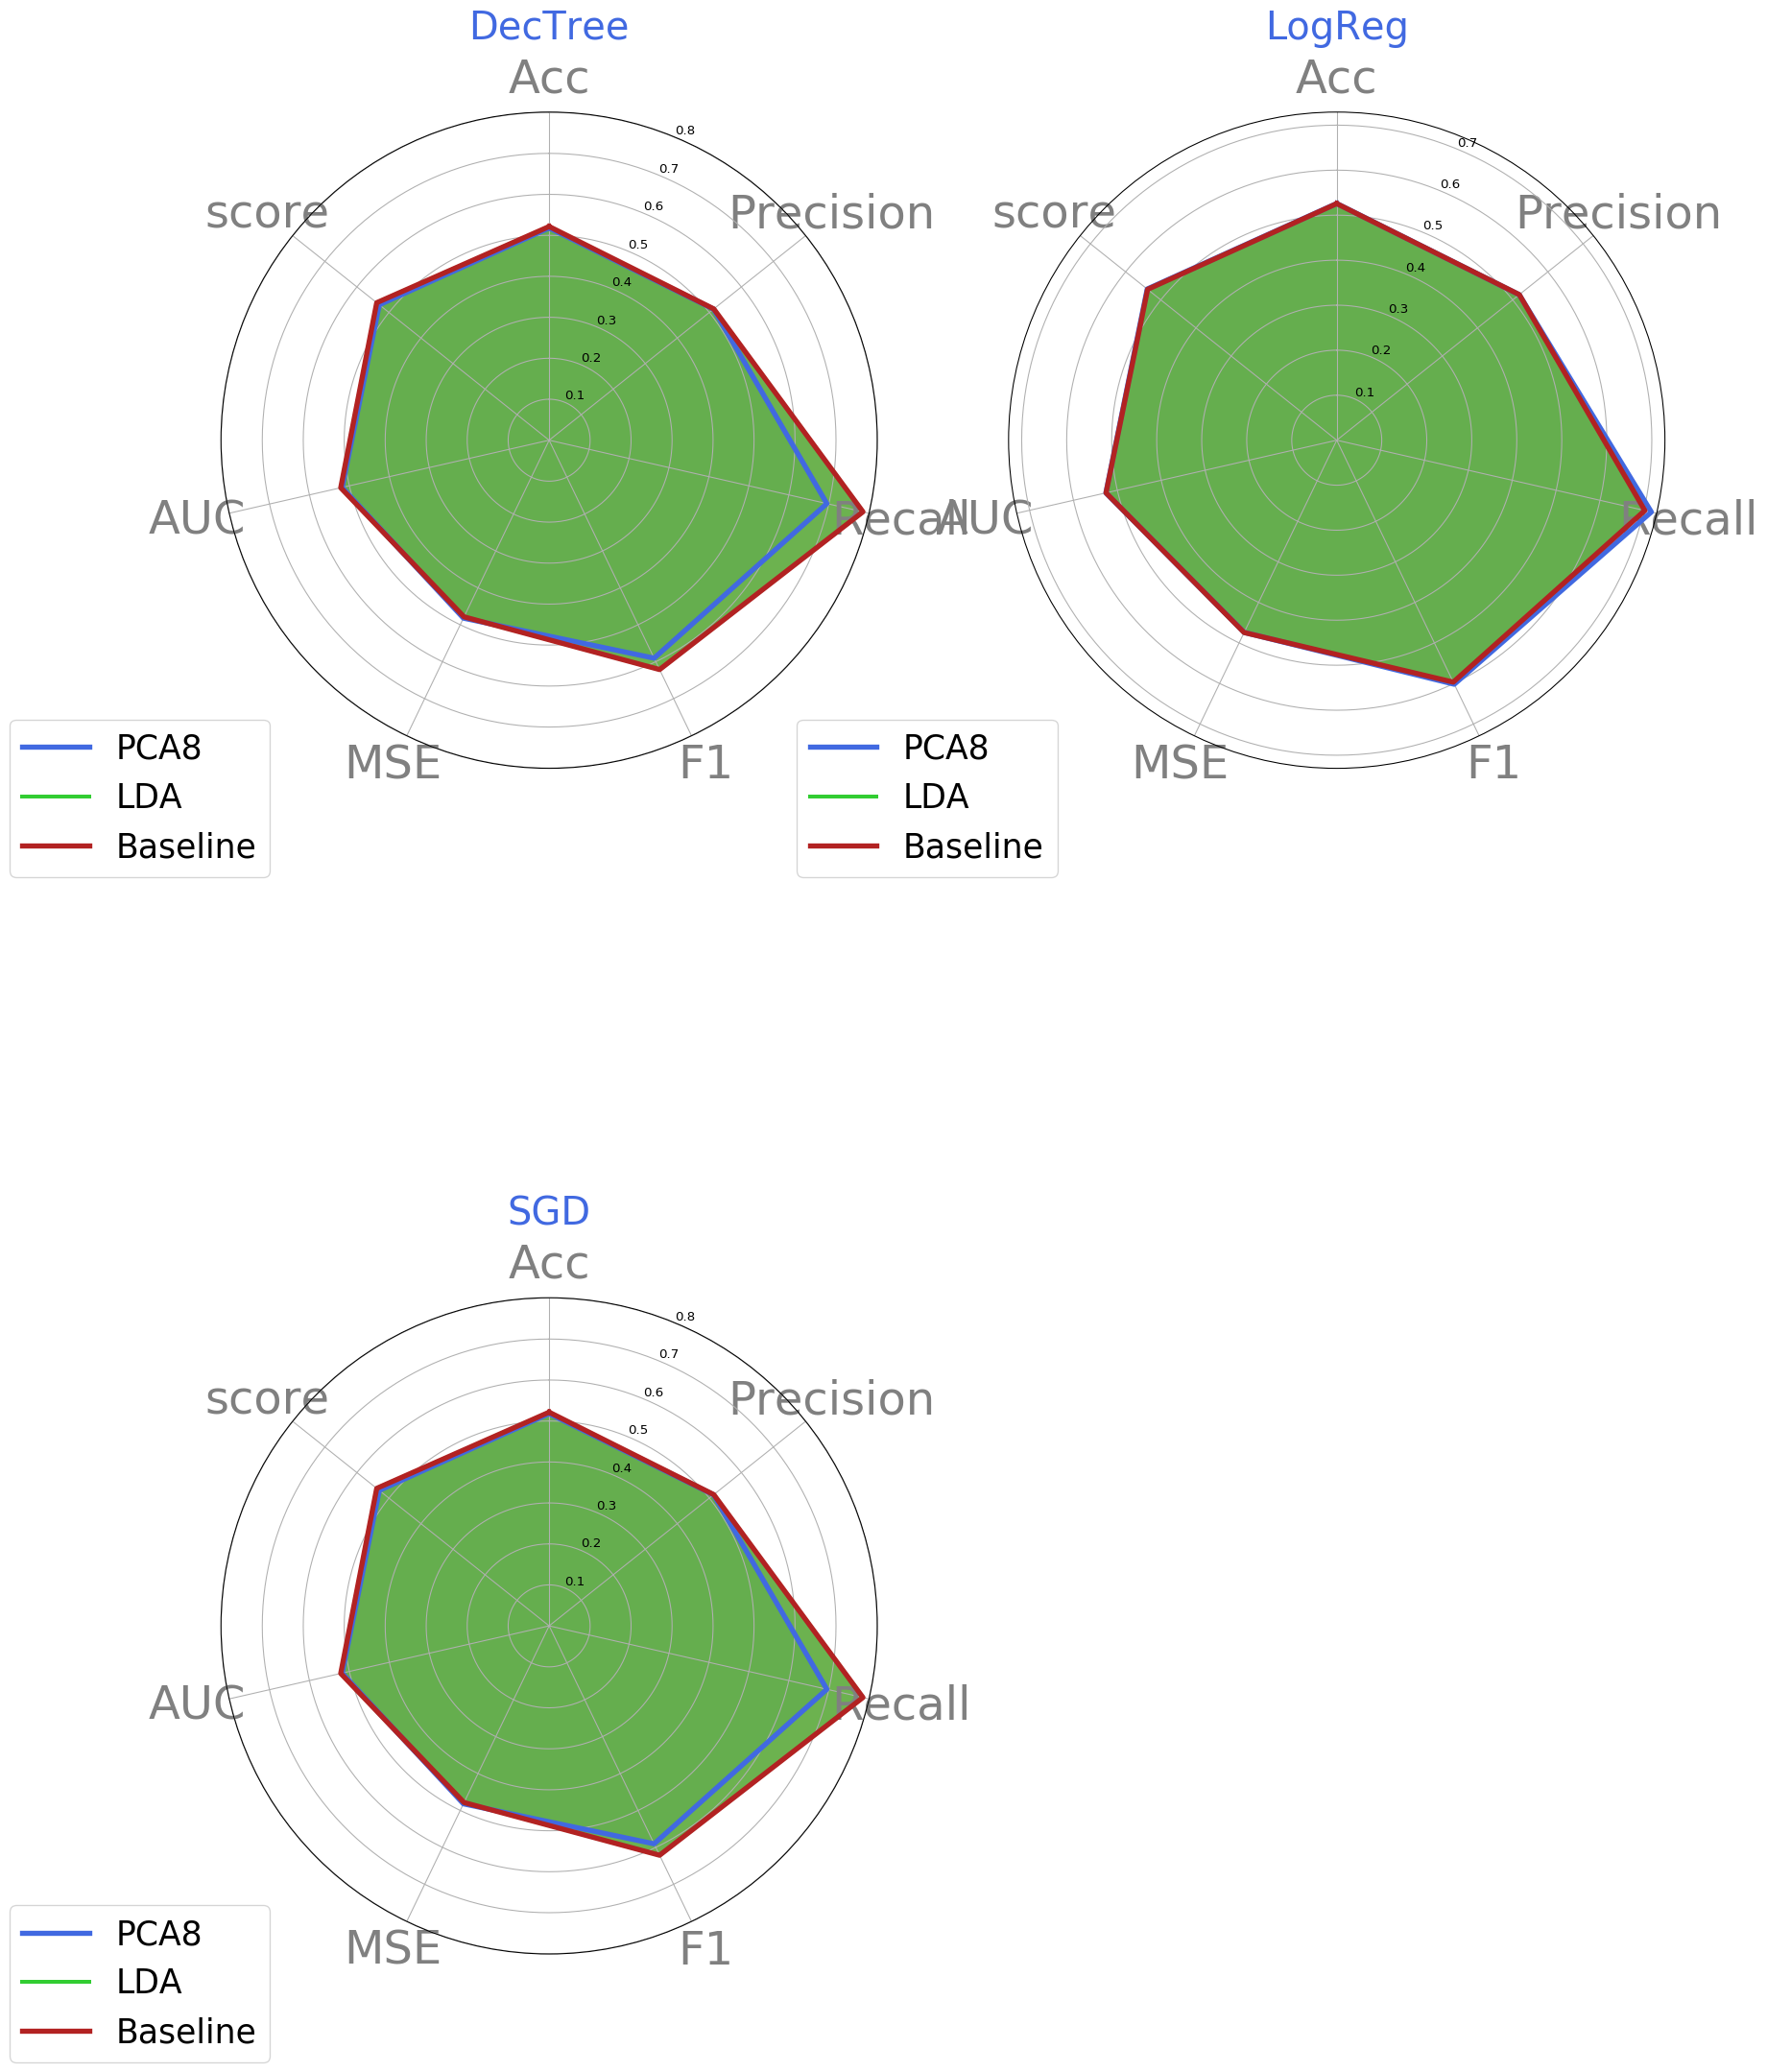

In [1346]:
feats = ['Algos','Acc','Precision','Recall','F1','MSE','AUC','Method','score']
df_plot = df1.loc[:,feats]
my_dpi=96
fig = plt.figure(figsize=(3000/my_dpi, 3000/my_dpi), dpi=my_dpi)

for row in range(0, len(df_plot.index), 2):
#    print(row, row+1, row+2)
    plot_spider(df_plot, row=row, title=df_plot['Algos'][row])
    
#fig.savefig('images/BaselineVsPCAVsLDA.png', dpi=fig.dpi)


Voting (h)

```python
#  ------- Voting (Manual) - hard 3s

# Prediction
# get validation predictions from each model

yhat = {
'SGD': clf1.predict(X_test),
'LR': clf2.predict(X_test_pca),
'DT': clf3.predict(X_test),
'RF': clf4.predict(X_test_lda),
'XT': clf5.predict(X_test_lda)}


ensemble_pred_hard = [np.bincount(list(r)).argmax() for r in np.c_[list(yhat.values())].T]


from sklearn.metrics import accuracy_score
hardRace = {}
res = pd.DataFrame()
for clf in (yhat.keys()):
    res = get_res(res, 0, clf, X_train, y_test, yhat[clf], 'DS')
    hardRace[clf]=accuracy_score(y_test, yhat[clf])
hardRace['hVoting'] = accuracy_score(y_test,ensemble_pred_hard)
dfVoting = pd.DataFrame.from_dict(hardRace, orient='index', columns=['Accuracy'])

# dfVoting has the baseline scores of accuracy for each of the classifier as well as the voting accuracy. 
dfVoting

def get_worse_classifier(yhat,it):
    # Remove those clfs that bring the acc's voting down
    my_dict = {}
    for i, clf in enumerate(yhat.keys()):
        my_dict = yhat.copy()
        my_dict.pop(clf, None)
        ensemble_pred_h = [np.bincount(list(r)).argmax() for r in np.c_[list(my_dict.values())].T]
        dfVoting[it+str(i)] = dfVoting['Accuracy']
        dfVoting.loc[clf,it+str(i)] = 0
        dfVoting.loc['hVoting',it+str(i)]=accuracy_score(y_test,ensemble_pred_h)

    return dfVoting

worse_classifier = get_worse_classifier(yhat,'1xIt_')
print(worse_classifier.max(axis=1))
worse_classifier

Bye bye xmas trees

yhat.pop('XT', None)
# Get the accuracy updated
dfVoting.loc['hVoting','Accuracy'] = 0.529390
itr = '2'
worse_classifier = get_worse_classifier(yhat,itr+'xIt_')
print(worse_classifier.max(axis=1))
worse_classifier.loc[:,worse_classifier.columns.str.startswith(itr)]

Bye bye LR

yhat.pop('LR', None)

# SGD and Dec Trees are the winners in best classifiers
# Confirmation:

from sklearn.metrics import accuracy_score

yhat_best = {
'SGD': clf1.predict(X_test),
'DT': clf3.predict(X_test)}
ensemble_pred_hard = [np.bincount(list(r)).argmax() for r in np.c_[list(yhat_best.values())].T]

hardRace = {}
for clf in (yhat.keys()):
    hardRace[clf]=accuracy_score(y_test, yhat[clf])
hardRace['hVoting'] = accuracy_score(y_test,ensemble_pred_hard)
dfVoting = pd.DataFrame.from_dict(hardRace, orient='index', columns=['Accuracy'])

dfVoting
```

#### Soft Voting

```python
#  ------- Voting  - soft 0.4 s

# INIT
vSoft = pd.DataFrame()
for c in yhat_s.keys():
    vs = pd.DataFrame(yhat_s[c][:,0]*-1, columns=[c+'_0'])
    vs[c+'_1'] = yhat_s[c][:,1]
    vSoft = pd.concat([vSoft,vs], axis=1)

vSoft["vs_0"] = vSoft.loc[:,vSoft.columns.str.endswith('_0')].mean(axis=1).apply(abs)
vSoft["vs_1"] = vSoft.loc[:,vSoft.columns.str.endswith('_1')].mean(axis=1)
vSoft['SoftVoting'] = vSoft.loc[:,vSoft.columns.str.startswith('vs')].idxmax(axis=1).apply(lambda x: x[-1]).astype(int)

from sklearn.metrics import accuracy_score
softRace = {}
res = pd.DataFrame()
for clf in (yhat_h.keys()):
    res = get_res(res, 0, clf, X_train, y_test, yhat_h[clf], 'Optimal')
    softRace[clf]=accuracy_score(y_test, yhat_h[clf])
softRace['sVoting'] = accuracy_score(y_test,vSoft.iloc[:,[-1]].values)
dfVoting = pd.DataFrame.from_dict(softRace, orient='index', columns=['Accuracy'])


dfVoting

my_dict = {}
my_dict = yhat_s.copy()
# dfVoting = get_worst_soft_clf(dfVoting, my_dict,'1xIt')
# print(dfVoting.max(axis=1))
# dfVoting
# def get_worst_soft_clf(dfVoting, my_dict,it):    
it = '1xIt'
my_df = pd.DataFrame()
for i, clf in enumerate(my_dict.keys()):
    # Remove clf
    my_df = vSoft.loc[:,(vSoft.columns.str.startswith(tuple(list(my_dict.keys()))))].copy()
    my_df.drop([clf+'_0',clf+'_1'], axis=1, inplace=True)
#     print(clf,'-',my_dict.keys(), my_df.columns)
    my_df["vs_0"] = my_df.loc[:,my_df.columns.str.endswith('_0')].mean(axis=1).apply(abs)
    my_df["vs_1"] = my_df.loc[:,my_df.columns.str.endswith('_1')].mean(axis=1)
    my_df['SoftVoting'] = my_df.loc[:,my_df.columns.str.startswith('vs')].idxmax(axis=1).apply(lambda x: x[-1]).astype(int)
    dfVoting[it+str(i)] = dfVoting['Accuracy']
    dfVoting.loc[clf,it+str(i)] = 0
    dfVoting.loc['sVoting',it+str(i)]=accuracy_score(y_test,my_df.iloc[:,[-1]].values)
print(dfVoting.max(axis=1))
dfVoting

# Bye bye RF

my_dict.pop('RF', None)

it = '2xIt'
for i, clf in enumerate(my_dict.keys()):
    # Remove clf
    my_df = vSoft.loc[:,(vSoft.columns.str.startswith(tuple(list(my_dict.keys()))))].copy()
    my_df.drop([clf+'_0',clf+'_1'], axis=1, inplace=True)
    my_df["vs_0"] = my_df.loc[:,my_df.columns.str.endswith('_0')].mean(axis=1).apply(abs)
    my_df["vs_1"] = my_df.loc[:,my_df.columns.str.endswith('_1')].mean(axis=1)
    my_df['SoftVoting'] = my_df.loc[:,my_df.columns.str.startswith('vs')].idxmax(axis=1).apply(lambda x: x[-1]).astype(int)

    dfVoting[it+str(i)] = dfVoting['Accuracy']
    dfVoting.loc[clf,it+str(i)] = 0
    dfVoting.loc['sVoting',it+str(i)]=accuracy_score(y_test,my_df.iloc[:,[-1]].values)
print(dfVoting.max(axis=1))
dfVoting

#### By bye XT

my_dict.pop('XT', None)
it = '3xIt'
for i, clf in enumerate(my_dict.keys()):
    # Remove clf
    my_df = vSoft.loc[:,(vSoft.columns.str.startswith(tuple(list(my_dict.keys()))))].copy()
    my_df.drop([clf+'_0',clf+'_1'], axis=1, inplace=True)
    my_df["vs_0"] = my_df.loc[:,my_df.columns.str.endswith('_0')].mean(axis=1).apply(abs)
    my_df["vs_1"] = my_df.loc[:,my_df.columns.str.endswith('_1')].mean(axis=1)
    my_df['SoftVoting'] = my_df.loc[:,my_df.columns.str.startswith('vs')].idxmax(axis=1).apply(lambda x: x[-1]).astype(int)

    dfVoting[it+str(i)] = dfVoting['Accuracy']
    dfVoting.loc[clf,it+str(i)] = 0
    dfVoting.loc['sVoting',it+str(i)]=accuracy_score(y_test,my_df.iloc[:,[-1]].values)
print(dfVoting.max(axis=1))
dfVoting.loc[:,dfVoting.columns.str.startswith(it)]

### Bye bye LR

my_dict.pop('LR', None)
it = '4xIt'
for i, clf in enumerate(my_dict.keys()):
    # Remove clf
    my_df = vSoft.loc[:,(vSoft.columns.str.startswith(tuple(list(my_dict.keys()))))].copy()
    my_df.drop([clf+'_0',clf+'_1'], axis=1, inplace=True)
    my_df["vs_0"] = my_df.loc[:,my_df.columns.str.endswith('_0')].mean(axis=1).apply(abs)
    my_df["vs_1"] = my_df.loc[:,my_df.columns.str.endswith('_1')].mean(axis=1)
    my_df['SoftVoting'] = my_df.loc[:,my_df.columns.str.startswith('vs')].idxmax(axis=1).apply(lambda x: x[-1]).astype(int)

    dfVoting[it+str(i)] = dfVoting['Accuracy']
    dfVoting.loc[clf,it+str(i)] = 0
    dfVoting.loc['sVoting',it+str(i)]=accuracy_score(y_test,my_df.iloc[:,[-1]].values)
print(dfVoting.max(axis=1))
dfVoting.loc[:,dfVoting.columns.str.startswith(it)]
```

---

#### Bagging and pasting

```python

#
start = time()
from sklearn.ensemble import BaggingClassifier
n_estimators=1000
bag_clf = BaggingClassifier(
    SGDClassifier(random_state=42,alpha=0.01,l1_ratio=0.25,loss='log',penalty='elasticnet'),
    n_estimators=n_estimators, n_jobs=-1, random_state=40, oob_score=True, bootstrap=True)
bag_clf.fit(X_train_lda, y_train)
y_pred = bag_clf.predict(X_test_lda)
clf_time = time()-start


# clf1 = SGDClassifier(random_state=42,alpha=0.01,l1_ratio=0.25,loss='log',penalty='elasticnet')
# clf2 = LogisticRegression(random_state=42)
# clf3 = DecisionTreeClassifier(random_state=42,max_leaf_nodes=91,min_samples_leaf=7,min_weight_fraction_leaf=0.01)

res = get_res(res, clf_time, 'RealSGD', X_train_lda, y_test, y_pred,'Bag1000:'+str(bag_clf.oob_score_))
print(clf_time, bag_clf.oob_score_)
res


# Pasting

#
start = time()
from sklearn.ensemble import BaggingClassifier
n_estimators=50
bag_clf = BaggingClassifier(
    SGDClassifier(random_state=42,alpha=0.01,l1_ratio=0.25,loss='log',penalty='elasticnet'), 
    n_estimators=n_estimators, n_jobs=-1, random_state=40) # , oob_score=True, bootstrap=True
bag_clf.fit(X_train_lda, y_train)
y_pred = bag_clf.predict(X_test_lda)
clf_time = time()-start
res = get_res(res, clf_time, 'SGD', X_train_lda, y_test, y_pred, 'Paste50')
print(clf_time) #, bag_clf.oob_score_)
res


# --- Boosting

# clf1 = SGDClassifier(random_state=42,alpha=0.01,l1_ratio=0.25,loss='log',penalty='elasticnet')
# clf2 = LogisticRegression(random_state=42)
# clf3 = DecisionTreeClassifier(random_state=42,max_leaf_nodes=91,min_samples_leaf=7,min_weight_fraction_leaf=0.01)

from sklearn.ensemble import AdaBoostClassifier
start = time()
ada_clf = AdaBoostClassifier(
    LogisticRegression(random_state=42), 
    n_estimators=50, algorithm="SAMME", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train_pca, y_train)
y_pred = ada_clf.predict(X_test_pca)
clf_time = time()-start




res = get_res(res, clf_time, 'LR', X_train_pca, y_test, y_pred,'ADA50')
print('Scores:',ada_clf.score(X_train_pca, y_train), ada_clf.score(X_test_pca, y_test))
res


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=49)

start = time()
#gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, learning_rate=1.0, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

print(bst_n_estimators)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)
y_pred = gbrt_best.predict(X_test)
y_pred_b = y_pred>=0.5



res = get_res(res, time()-start, 'GBoostBest', X_train, y_test, y_pred_b, 'GBoost')
res

```

In [42]:
results = '''sVote_SGD&DT	(878147, 16)	0.000000	0.537173	0.530727	0.637132	0.579082	0.462827	0.537234	SoftVote
RF	(878147, 1)	1730.083486	0.527019	0.522466	0.621585	0.567732	0.472981	0.527077	Paste50
DT	(878147, 1)	46.867335	0.526780	0.522297	0.620491	0.567175	0.473220	0.526838	Paste50
LR	(878147, 1)	62.578396	0.525694	0.518806	0.700762	0.596210	0.474306	0.525801	Paste50
SGD	(878147, 1)	67.679899	0.525318	0.518031	0.718995	0.602189	0.474682	0.525437	Paste50
DT	(878147, 16)	0.000000	0.536623	0.531393	0.615090	0.570186	0.463377	0.536671	Optimal
RF	(878147, 16)	0.000000	0.527129	0.522657	0.619090	0.566801	0.472871	0.527185	Optimal
SGD	(878147, 16)	0.000000	0.526005	0.517935	0.742548	0.610229	0.473995	0.526138	Optimal
LR	(878147, 16)	0.000000	0.525974	0.518576	0.716965	0.601843	0.474026	0.526091	Optimal
XT	(878147, 16)	0.000000	0.525878	0.519274	0.689331	0.592339	0.474122	0.525979	Optimal
hVote_SGD&DT	(878147, 16)	0.000000	0.537600	0.535174	0.567752	0.550982	0.462400	0.537618	HardVote
DT	(878147, 16)	527.436020	0.536776	0.531077	0.623602	0.573632	0.463224	0.536830	Bag50:0.5421176636713443
RF	(878147, 1)	1900.264808	0.527019	0.522466	0.621585	0.567732	0.472981	0.527077	Bag50:0.530570622002922
DT	(878147, 1)	49.974618	0.526780	0.522297	0.620491	0.567175	0.473220	0.526838	Bag50:0.5304123341536212
DT	(878147, 1)	991.391237	0.526418	0.521791	0.625612	0.569004	0.473582	0.526479	Bag1000:0.5301037297855599
DT	(878147, 1)	522.211582	0.526394	0.521793	0.624990	0.568748	0.473606	0.526455	Bag500:0.5302289935511936
LR	(878147, 8)	126.454752	0.526111	0.518706	0.715953	0.601573	0.473889	0.526227	Bag50:0.5309247768312139
LR	(878147, 1)	128.848245	0.525735	0.518808	0.701814	0.596593	0.474265	0.525843	Bag100:0.5301902756599977
SGD	(878147, 16)	191.692078	0.525673	0.517501	0.750526	0.612602	0.474327	0.525812	Bag50:0.5299602458358339
LR	(878147, 1)	64.263366	0.525694	0.518806	0.700762	0.596210	0.474306	0.525801	Bag50:0.5301834430909631
LR	(878147, 1)	662.846165	0.525687	0.518768	0.701965	0.596620	0.474313	0.525795	Bag500:0.5301230887311578
LR	(878147, 1)	1277.406440	0.525629	0.518713	0.702314	0.596710	0.474371	0.525738	Bag1000:0.5301151174006175
SGD	(878147, 1)	73.287084	0.525318	0.518031	0.718995	0.602189	0.474682	0.525437	Bag50:0.529821316932131
SGD	(878147, 1)	783.553325	0.525233	0.517939	0.720096	0.602512	0.474767	0.525352	Bag500:0.5296937756434856
DT	(878147, 1)	151.321925	0.525229	0.517910	0.721128	0.602854	0.474771	0.525350	Bag100:0.5297518524802795
SGD	(878147, 1)	1519.043180	0.525229	0.517911	0.721094	0.602842	0.474771	0.525350	Bag1000:0.5297450199112449
LR	(878147, 16)	414.239499	0.525916	0.518903	0.703421	0.597235	0.474084	0.526025	Bag50:0.5303041518105739
SGD	(878147, 16)	191.692078	0.525673	0.517501	0.750526	0.612602	0.474327	0.525812	Bag50:0.5299602458358339
LR	(878147, 16)	527.436020	0.536776	0.531077	0.623602	0.573632	0.463224	0.536830	Bag50:0.5421176636713443
DT	(878147, 16)	414.239499	0.525916	0.518903	0.703421	0.597235	0.474084	0.526025	Bag50:0.5303041518105739
SGD	(878147, 16)	122.986392	0.525786	0.517606	0.749501	0.612334	0.474214	0.525924	Paste50
LR	(878147, 16)	263.610281	0.525772	0.518819	0.702464	0.596834	0.474228	0.525881	Paste50
DT	(878147, 16)	342.414133	0.536974	0.531299	0.622809	0.573426	0.463026	0.537027	Paste50
RF	(878147, 1)	5755.149308	0.525246	0.520479	0.634206	0.571742	0.474754	0.525313	ADA50
SGD	(878147, 16)	6.907644	0.499693	0.499693	1.000000	0.666393	0.500307	0.500000	ADA50
DT	(878147, 16)	1064.653176	0.533268	0.529505	0.591879	0.558957	0.466732	0.533304	ADA50
GBoostBest	(658610, 16)	428.957976	0.537176	0.531864	0.615774	0.570751	0.462824	0.537224	GBoost
LR	(878147, 8)	84.645246	0.528437	0.523336	0.631232	0.572242	0.471563	0.528500	ADA50'''

In [44]:
n_cols = ['Algos','data_size','ETA','Acc','Precision','Recall','F1','MSE','AUC','Method']#.split('\t')
# Initialize dataframe

df1 = pd.DataFrame(columns=n_cols)
# Fill info
for i,r1 in enumerate(results.split('\n')):
    df1.loc[i] = r1.split('\t')


df1[['Acc', 'Precision', 'Recall', 'F1', 'MSE', 'AUC']] = df1[['Acc', 'Precision', 'Recall', 'F1', 'MSE', 'AUC']].apply(pd.to_numeric) 
df1['score'] = df1.apply(lambda row: ((row.Acc+row.F1+row.AUC)/3+1-row.MSE)*0.5, axis=1)
# Order index
df1.set_index('Algos', inplace=True)
df1.sort_index(inplace=True)
df1.reset_index(inplace=True)
df1.loc[:,['Algos','data_size','ETA','Acc','F1','MSE','AUC','score','Method']].sort_values(['Algos','score'], ascending=False).head()


,Algos,data_size,ETA,Acc,F1,MSE,AUC,score,Method
37,sVote_SGD&DT,"(878147, 16)",0.000000,0.537173,0.579082,0.462827,0.537234,0.544168,SoftVote
36,hVote_SGD&DT,"(878147, 16)",0.000000,0.537600,0.550982,0.462400,0.537618,0.539833,HardVote
35,XT,"(878147, 16)",0.000000,0.525878,0.592339,0.474122,0.525979,0.536972,Optimal
27,SGD,"(878147, 16)",122.986392,0.525786,0.612334,0.474214,0.525924,0.540234,Paste50
28,SGD,"(878147, 16)",191.692078,0.525673,0.612602,0.474327,0.525812,0.540184,Bag50:0.5299602458358339


In [45]:
df1.drop(34, inplace=True)
df1.loc[21,'Method'] = 'Bag50:0.54218'
df1.loc[22,'Method'] = 'Bag50:0.53057'

'''Voting on 
27 SGD Paste50
22 RF Bag50
35 XT Optimal
21 LR Bag50
6 DT Paste50
10 GBoostBest'''

In [50]:
df1.loc[[6,10,21,22,27,35],['Algos','data_size','ETA','Acc','F1','MSE','AUC','score','Method']].sort_values(['score'], ascending=False)


,Algos,data_size,ETA,Acc,F1,MSE,AUC,score,Method
6,DT,"(878147, 16)",342.414133,0.536974,0.573426,0.463026,0.537027,0.543058,Paste50
21,LR,"(878147, 16)",527.436020,0.536776,0.573632,0.463224,0.536830,0.542928,Bag50:0.54218
10,GBoostBest,"(658610, 16)",428.957976,0.537176,0.570751,0.462824,0.537224,0.542780,GBoost
27,SGD,"(878147, 16)",122.986392,0.525786,0.612334,0.474214,0.525924,0.540234,Paste50
35,XT,"(878147, 16)",0.000000,0.525878,0.592339,0.474122,0.525979,0.536972,Optimal
22,RF,"(878147, 1)",1900.264808,0.527019,0.567732,0.472981,0.527077,0.533814,Bag50:0.53057


# Voting 
BaggingClassifier 0.5257724210497547
BaggingClassifier 0.5257860861722625
BaggingClassifier 0.5369744052255429
Vh_SGD&DT&LR 0.527760696374643


SGD	0.5257860861722625
DT	0.5369744052255429
Vh_SGD&DT	0.5381325243580809

```python

from sklearn.ensemble import BaggingClassifier


n_estimators=50

# -- LR
lr_bag_clf = BaggingClassifier(
    LogisticRegression(random_state=42),
    n_estimators=n_estimators, n_jobs=1, random_state=40, oob_score=True, bootstrap=True)

# --- SGD
sgd_paste_clf = BaggingClassifier(
    SGDClassifier(random_state=42,alpha=0.01,l1_ratio=0.25,loss='log',penalty='elasticnet'),
    n_estimators=n_estimators, n_jobs=1, random_state=40)
# --- DT
dt_paste_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42,max_leaf_nodes=91,min_samples_leaf=7,min_weight_fraction_leaf=0.01),
    n_estimators=n_estimators, n_jobs=1, random_state=40)

# --- RF
n_estimators=50
rf_bag_clf = BaggingClassifier(
    RandomForestClassifier(random_state=42,max_leaf_nodes=93,min_samples_leaf=1,min_samples_split=11,n_estimators=43),
    n_estimators=n_estimators, n_jobs=1, random_state=40, oob_score=True, bootstrap=True)

# --- XT
xt_opt_clf = ExtraTreesClassifier(random_state=42,max_leaf_nodes=97,min_samples_leaf=2,min_samples_split=9,n_estimators=47)




start = time()
lr_bag_clf.fit(X_train, y_train)
sgd_paste_clf.fit(X_train, y_train)
dt_paste_clf.fit(X_train, y_train)
rf_bag_clf.fit(X_train_lda, y_train)
xt_opt_clf.fit(X_train, y_train)

yhat_h = {
'SGD': sgd_paste_clf.predict(X_test),
'LR': lr_bag_clf.predict(X_test),
'DT': dt_paste_clf.predict(X_test),
'RF': rf_bag_clf.predict(X_test_lda),
'XT': xt_opt_clf.predict(X_test)}

yhat_s = {
'SGD': sgd_paste_clf.predict_proba(X_test),
'LR': lr_bag_clf.predict_proba(X_test),
'DT': dt_paste_clf.predict_proba(X_test),
'RF': rf_bag_clf.predict_proba(X_test_lda),
'XT': xt_opt_clf.predict_proba(X_test)}
```

In [31]:
testdict={
    123: [2,4],
    234: [6,8],
    456: [10, 12]
}
df = pd.DataFrame(testdict)


In [37]:
type(testdict.values())

dict_values